# SWB Computational Models

- Winning model from 2014 "A computational and neural model of momentary subjective well-being"
- Adapted to include counterfactual information 

Created: 05/04/2023 by Alie Fink
Updated: 01/14/2024

In [204]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
import scipy
from scipy.optimize import least_squares, minimize
import sklearn
from sklearn.metrics import r2_score
import random
import tqdm
from scipy.stats import spearmanr, norm
import statsmodels.api as sm
import os
import pickle
import datetime
from joblib import Parallel, delayed
import itertools
from scipy.stats import mannwhitneyu, normaltest


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [126]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/scripts/')
import SWB_modeling_utils, SWB_behav_utils

In [155]:
# set directories
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/'
behav_dir = f'{base_dir}behavior_analysis/behavior_preprocessed/'
# create fig saving directory
fig_dir = f'{base_dir}swb_computational_modeling/swb_behav_models/figs/swb_pt_glms/'
os.makedirs(fig_dir,exist_ok = True) 

# get date info for data/fig saving
date = datetime.date.today().strftime('%m%d%Y')
print(date)

01232024


In [5]:
subj_list = pd.read_excel(f'{base_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0])
subj_ids = list(subj_list.PatientID)

In [6]:
bdi_list = pd.read_excel(f'{base_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
bai_list = pd.read_excel(f'{base_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[4])
bai_list = list(bai_list.SWB_BAI)

In [10]:
%matplotlib inline

#### set theme for all plots
sns.set_theme(style='ticks',font='Arial') 
sns.set_context("talk")

# Prospect Theory Parameters for SWB Subj
- save data into task dfs
- create regression df for ephys regression
- update model_data inputs for GLMs

In [11]:
# load subj fits for mle + em map 

pt_mle_fits = pickle.load(open(f'{base_dir}swb_computational_modeling/swb_behav_models/data/swb_pt_subj_fits/swb_pt_MLE_dict_{date}.pkl','rb'))
# pt_mle_fits
pt_emmap_fits = pickle.load(open(f'{base_dir}swb_computational_modeling/swb_behav_models/data/swb_pt_subj_fits/swb_pt_EMMAP_fit_subj_dicts_{date}.pkl','rb')) 
# pt_emmap_fits


In [12]:
# MLE 
# extract estimated params for all subj

risk_mle    = []
loss_mle    = []
invtemp_mle = []
negll_mle   = []
bic_mle     = []


for subj_id in subj_ids: 
    subj_data = pt_mle_fits[subj_id]['subj_dict']
    risk_mle.append(subj_data['params'][0])
    loss_mle.append(subj_data['params'][1])
    invtemp_mle.append(subj_data['params'][2])
    negll_mle.append(subj_data['negll'])
    bic_mle.append(subj_data['BIC'])
    

In [13]:
# EM MAP 
# extract estimated params for all subj

risk_emmap     = []
loss_emmap     = []
invtemp_emmap  = []
negll_emmap    = []
bic_emmap      = []


for subj_id in subj_ids: 
    subj_data = pt_emmap_fits[subj_id]
    risk_emmap.append(subj_data['params'][0])
    loss_emmap.append(subj_data['params'][1])
    invtemp_emmap.append(subj_data['params'][2])
    negll_emmap.append(subj_data['negll'])
    bic_emmap.append(subj_data['bic'])

In [14]:
# combine mle and emmap info into df + save

### make summary df of all pt info 
df_data_dict = {'subj_id':subj_ids,'risk_mle':risk_mle,'loss_mle':loss_mle,'invtemp_mle':invtemp_mle,'negll_mle':negll_mle,'bic_mle':bic_mle,
                'risk_emmap':risk_emmap,'loss_emmap':loss_emmap,'invtemp_emmap':invtemp_emmap,'negll_emmap':negll_emmap,'bic_emmap':bic_emmap,
                'bdi':bdi_list,'bai':bai_list}

pt_params_df = pd.DataFrame(df_data_dict)
pt_params_df.to_csv(f'{base_dir}swb_computational_modeling/swb_behav_models/data/swb_pt_subj_fits/pt_params_mle_emmap_df_{date}.csv')
    
pt_params_df

subj_id  risk_mle  loss_mle  invtemp_mle   negll_mle     bic_mle  \
0      DA8  1.212121  5.111117     2.625557   55.476387  125.984681   
1      DA9  1.484386  0.836855     3.261053   81.634586  178.301077   
2     DA10  0.781768  1.727190     3.058602   90.215432  195.462769   
3     DA11  1.199625  0.226255     1.527750   96.929642  208.891190   
4    DA023  0.994608  1.864381     2.089041   91.022847  197.077600   
5    DA026  0.564950  2.148784     2.429444   88.984904  193.001714   
6    MS001  1.150583  0.000010     2.058961   95.560060  206.152026   
7    MS002  0.817053  3.421697     1.387247   88.149899  191.331703   
8    MS003  0.733124  0.000010     5.115220   85.857590  186.747086   
9    MS004  0.711023  6.000000     0.316979  100.327488  215.686883   
10   MS009  1.236865  1.717930     1.107706   97.608501  210.248908   
11   MS011  1.434220  1.282388     1.594878   92.179951  199.391807   
12   MS015  1.213110  0.000010     2.133127   90.148678  195.329262   
13   MS016  0.623760  0.969737     6.760218   87.034070  189.100046   
14   MS017  1.325976  0.989178     6.336838   66.908907  148.849720   
15   MS019  1.141830  0.000010     6.782407   76.959423  168.950752   
16   MS020  0.676425  6.000000     0.532026   94.543918  204.119741   
17   MS022  1.921448  0.102132     3.493743   80.041619  175.115144   
18   MS024  0.632069  6.000000     1.307602   60.118980  135.269867   
19   MS025  0.852421  6.000000     1.103802   78.671177  172.374261   
20   MS026  1.442294  1.728298     1.999431   83.092609  181.217124   
21   MS027  0.641948  0.648616     5.595924   95.147044  205.325993   
22   MS028  1.774330  0.566186     9.505228   52.999677  121.031259   
23   MS029  0.000010  0.603728     0.722101  100.012237  215.056380   
24   MS030  0.732821  1.144258     5.357345   90.226620  195.485147   
25   MS033  2.000000  0.222575     5.713790   71.600376  158.232658   
26   MS035  1.570579  0.384711     1.056864   98.926805  212.885516   

    risk_emmap  loss_emmap  invtemp_emmap  negll_emmap   bic_emmap  bdi  bai  
0     1.172729    3.828213       3.392080    55.827057  126.686020   13    0  
1     1.360678    0.821322       3.599438    81.843522  178.718950   32    0  
2     0.800344    1.679324       3.101616    90.238324  195.508554   11    0  
3     1.038362    0.393018       2.126357    97.190163  209.412232   41    0  
4     0.978743    1.726643       2.396959    91.088155  197.208215   14    0  
5     0.590881    1.919778       2.900346    89.086917  193.205739   19   36  
6     1.026281    0.085576       2.325856    96.690143  208.412192   24    0  
7     0.812426    2.404264       2.218737    88.441836  191.915578   14    0  
8     0.762030    0.105420       4.770961    86.710069  188.452043    8    0  
9     0.705524    1.930037       1.430658   101.518070  218.068045    7    4  
10    1.102662    1.467795       1.651399    97.964299  210.960503   16   42  
11    1.273975    1.136010       2.134412    92.526369  200.084645   13   35  
12    1.052418    0.079646       2.415907    91.329902  197.691710   26    7  
13    0.645006    0.997816       5.339087    87.466539  189.964985   10    5  
14    1.328684    1.030942       5.454796    67.149698  149.331302   26   27  
15    1.111526    0.041384       5.476528    78.739975  172.511855   12   36  
16    0.629143    2.291833       1.830896    95.482790  205.997486    6   13  
17    1.305384    0.234459       4.326151    80.829790  176.691486   10   11  
18    0.675271    3.968670       2.099378    61.471074  137.974055   16   10  
19    0.820272    4.164168       1.690672    80.134567  175.301040   10    7  
20    1.298253    1.594477       2.472335    83.377587  181.787081    9   11  
21    0.672341    0.653941       4.621314    95.390157  205.812220   22   16  
22    1.543123    0.681786       6.912464    55.157957  125.347820   12    5  
23    0.571545    0.637798       2.212192   100.574171  216.180249   32   23  
24    0.765764    1.153757       4.5751

In [17]:
# summary stats for fit quality
    # param means
    # param ranges
    # params @ bounds

pt_summary_df = {'risk_mle_mean':np.mean(risk_mle),'risk_mle_min':np.min(risk_mle),'risk_mle_max':np.max(risk_mle),
              'n_risk_bad_mle':[np.sum(pt_params_df.risk_mle==2)+np.sum(pt_params_df.risk_mle==0.00001)],
              'loss_mle_mean':np.mean(loss_mle),'loss_mle_min':np.min(loss_mle),'loss_mle_max':np.max(loss_mle),
              'n_loss_bad_mle':[np.sum(pt_params_df.loss_mle==6)+np.sum(pt_params_df.loss_mle==0.00001)],
              'invtemp_mle_mean':np.mean(invtemp_mle),'invtemp_mle_min':np.min(invtemp_mle),'invtemp_mle_max':np.max(invtemp_mle),
              'n_invtemp_bad_mle':[np.sum(pt_params_df.invtemp_mle==10)+np.sum(pt_params_df.invtemp_mle==0.00001)],
              'bic_mean_mle':np.mean(bic_mle),'bic_min_mle':np.min(bic_mle),'bic_max_mle':np.max(bic_mle),
              'negll_mean_mle':np.mean(negll_mle),'negll_min_mle':np.min(negll_mle),'negll_max_mle':np.max(negll_mle),
#
              'risk_emmap_mean':np.mean(risk_emmap),'risk_emmap_min':np.min(risk_emmap),'risk_emmap_max':np.max(risk_emmap),
              'n_risk_bad_emmap':[np.sum(pt_params_df.risk_emmap==2)+np.sum(pt_params_df.risk_emmap==0.00001)],
              'loss_emmap_mean':np.mean(loss_emmap),'loss_emmap_min':np.min(loss_emmap),'loss_emmap_max':np.max(loss_emmap),
              'n_loss_bad_emmap':[np.sum(pt_params_df.loss_emmap==6)+np.sum(pt_params_df.loss_emmap==0.00001)],
              'invtemp_emmap_mean':np.mean(invtemp_emmap),'invtemp_emmap_min':np.min(invtemp_emmap),'invtemp_emmap_max':np.max(invtemp_emmap),
              'n_invtemp_bad_emmap':[np.sum(pt_params_df.invtemp_emmap==10)+np.sum(pt_params_df.invtemp_emmap==0.00001)],
              'bic_mean_emmap':np.mean(bic_emmap),'bic_min_emmap':np.min(bic_emmap),'bic_max_emmap':np.max(bic_emmap),
              'negll_mean_emmap':np.mean(negll_emmap),'negll_min_emmap':np.min(negll_emmap),'negll_max_emmap':np.max(negll_emmap)}


pt_summary_df = pd.DataFrame(pt_summary_df)
pt_summary_df.to_csv(f'{base_dir}swb_computational_modeling/swb_behav_models/data/swb_pt_subj_fits/pt_summary_mle_emmap_df_{date}.csv')


In [18]:
all_pt_data = {}

for subj_id in subj_ids: 
    # get mle df 
    mle_data = pt_mle_fits[subj_id]['subj_dict']
    # get emmap df 
    emmap_data = pt_emmap_fits[subj_id]
    all_pt_data[subj_id] = {'mle_data':mle_data,
                            'emmap_data':emmap_data
                            }
    

In [34]:
behav_dir

'/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

In [36]:
pt_task_dfs = SWB_modeling_utils.get_pt_task_data_mle_emmap(subj_ids,behav_dir,pt_mle_fits,pt_emmap_fits)
# pt_task_dfs

## Visualize Param Fits from MLE and EM MAP

In [37]:
pt_params_df

subj_id  risk_mle  loss_mle  invtemp_mle   negll_mle     bic_mle  \
0      DA8  1.212121  5.111117     2.625557   55.476387  125.984681   
1      DA9  1.484386  0.836855     3.261053   81.634586  178.301077   
2     DA10  0.781768  1.727190     3.058602   90.215432  195.462769   
3     DA11  1.199625  0.226255     1.527750   96.929642  208.891190   
4    DA023  0.994608  1.864381     2.089041   91.022847  197.077600   
5    DA026  0.564950  2.148784     2.429444   88.984904  193.001714   
6    MS001  1.150583  0.000010     2.058961   95.560060  206.152026   
7    MS002  0.817053  3.421697     1.387247   88.149899  191.331703   
8    MS003  0.733124  0.000010     5.115220   85.857590  186.747086   
9    MS004  0.711023  6.000000     0.316979  100.327488  215.686883   
10   MS009  1.236865  1.717930     1.107706   97.608501  210.248908   
11   MS011  1.434220  1.282388     1.594878   92.179951  199.391807   
12   MS015  1.213110  0.000010     2.133127   90.148678  195.329262   
13   MS016  0.623760  0.969737     6.760218   87.034070  189.100046   
14   MS017  1.325976  0.989178     6.336838   66.908907  148.849720   
15   MS019  1.141830  0.000010     6.782407   76.959423  168.950752   
16   MS020  0.676425  6.000000     0.532026   94.543918  204.119741   
17   MS022  1.921448  0.102132     3.493743   80.041619  175.115144   
18   MS024  0.632069  6.000000     1.307602   60.118980  135.269867   
19   MS025  0.852421  6.000000     1.103802   78.671177  172.374261   
20   MS026  1.442294  1.728298     1.999431   83.092609  181.217124   
21   MS027  0.641948  0.648616     5.595924   95.147044  205.325993   
22   MS028  1.774330  0.566186     9.505228   52.999677  121.031259   
23   MS029  0.000010  0.603728     0.722101  100.012237  215.056380   
24   MS030  0.732821  1.144258     5.357345   90.226620  195.485147   
25   MS033  2.000000  0.222575     5.713790   71.600376  158.232658   
26   MS035  1.570579  0.384711     1.056864   98.926805  212.885516   

    risk_emmap  loss_emmap  invtemp_emmap  negll_emmap   bic_emmap  bdi  bai  
0     1.172729    3.828213       3.392080    55.827057  126.686020   13    0  
1     1.360678    0.821322       3.599438    81.843522  178.718950   32    0  
2     0.800344    1.679324       3.101616    90.238324  195.508554   11    0  
3     1.038362    0.393018       2.126357    97.190163  209.412232   41    0  
4     0.978743    1.726643       2.396959    91.088155  197.208215   14    0  
5     0.590881    1.919778       2.900346    89.086917  193.205739   19   36  
6     1.026281    0.085576       2.325856    96.690143  208.412192   24    0  
7     0.812426    2.404264       2.218737    88.441836  191.915578   14    0  
8     0.762030    0.105420       4.770961    86.710069  188.452043    8    0  
9     0.705524    1.930037       1.430658   101.518070  218.068045    7    4  
10    1.102662    1.467795       1.651399    97.964299  210.960503   16   42  
11    1.273975    1.136010       2.134412    92.526369  200.084645   13   35  
12    1.052418    0.079646       2.415907    91.329902  197.691710   26    7  
13    0.645006    0.997816       5.339087    87.466539  189.964985   10    5  
14    1.328684    1.030942       5.454796    67.149698  149.331302   26   27  
15    1.111526    0.041384       5.476528    78.739975  172.511855   12   36  
16    0.629143    2.291833       1.830896    95.482790  205.997486    6   13  
17    1.305384    0.234459       4.326151    80.829790  176.691486   10   11  
18    0.675271    3.968670       2.099378    61.471074  137.974055   16   10  
19    0.820272    4.164168       1.690672    80.134567  175.301040   10    7  
20    1.298253    1.594477       2.472335    83.377587  181.787081    9   11  
21    0.672341    0.653941       4.621314    95.390157  205.812220   22   16  
22    1.543123    0.681786       6.912464    55.157957  125.347820   12    5  
23    0.571545    0.637798       2.212192   100.574171  216.180249   32   23  
24    0.765764    1.153757       4.5751

In [21]:
risk_corr, risk_p = spearmanr(pt_params_df.risk_mle, pt_params_df.risk_emmap)
print('Spearman correlation: %.3f' % risk_corr)
print(risk_p)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Spearman correlation: 0.957
5.579061557313431e-15


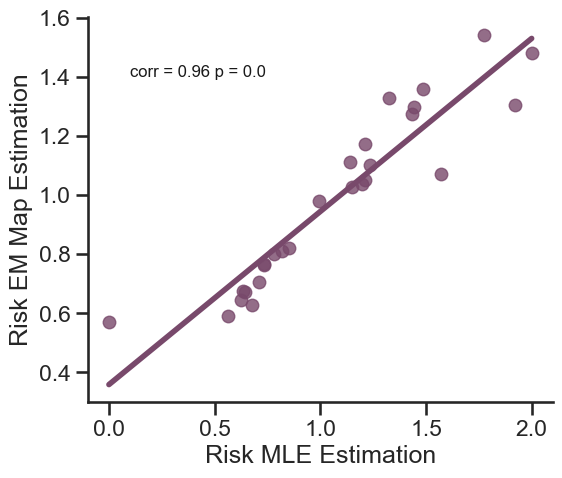

In [22]:
## MLE vs EM MAP Risk Estimations
# plt.scatter(subj_bdi,risk_est,color = '#78496b')
fig,ax = plt.subplots(figsize=(6,5))

sns.regplot(ax=ax,x=pt_params_df.risk_mle, y=pt_params_df.risk_emmap,color = '#78496b',ci=None,scatter=True,line_kws={"linewidth": 4})
ax.text(0.1, 1.4,f'corr = {np.round(risk_corr,2)} p = {np.round(risk_p,12)}',fontsize=12,color = 'k')
plt.xlabel('Risk MLE Estimation')
plt.ylabel('Risk EM Map Estimation')
sns.despine()


plt.savefig(f'{fig_dir}risk_mle_emmap_corr_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

In [23]:
loss_corr, loss_p = spearmanr(pt_params_df.loss_mle, pt_params_df.loss_emmap)
print('Spearman correlation: %.3f' % loss_corr)
print(loss_p)

Spearman correlation: 0.983Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

7.037334517354076e-20


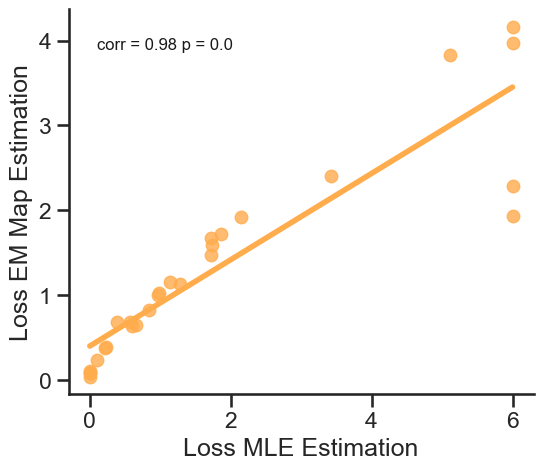

In [24]:
## MLE vs EM MAP Risk Estimations
# plt.scatter(subj_bdi,risk_est,color = '#78496b')
fig,ax = plt.subplots(figsize=(6,5))

sns.regplot(ax=ax,x=pt_params_df.loss_mle, y=pt_params_df.loss_emmap,color = '#ffac4d',ci=None,scatter=True,line_kws={"linewidth": 4})
ax.text(0.1, 3.9,f'corr = {np.round(loss_corr,2)} p = {np.round(loss_p,13)}',fontsize=12,color = 'k')
plt.xlabel('Loss MLE Estimation')
plt.ylabel('Loss EM Map Estimation')
sns.despine()


plt.savefig(f'{fig_dir}loss_mle_emmap_corr_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

In [25]:
invtemp_corr, invtemp_p = spearmanr(pt_params_df.invtemp_mle, pt_params_df.invtemp_emmap)
print('Spearman correlation: %.3f' % invtemp_corr)
print(invtemp_p)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Spearman correlation: 0.969
8.884858258183791e-17


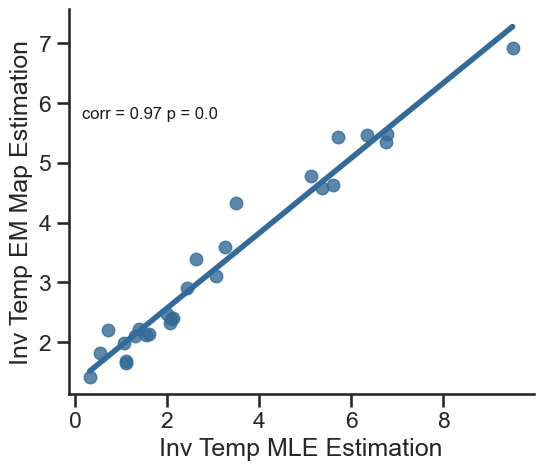

In [26]:
## MLE vs EM MAP Risk Estimations
# plt.scatter(subj_bdi,risk_est,color = '#78496b')
fig,ax = plt.subplots(figsize=(6,5))

sns.regplot(ax=ax,x=pt_params_df.invtemp_mle, y=pt_params_df.invtemp_emmap,color = '#346a97',ci=None,scatter=True,line_kws={"linewidth": 4})
ax.text(0.15, 5.75,f'corr = {np.round(invtemp_corr,2)} p = {np.round(invtemp_p,12)}',fontsize=12,color = 'k')
plt.xlabel('Inv Temp MLE Estimation')
plt.ylabel('Inv Temp EM Map Estimation')
sns.despine()


plt.savefig(f'{fig_dir}invtemp_mle_emmap_corr_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

In [27]:
pt_params_df

subj_id  risk_mle  loss_mle  invtemp_mle   negll_mle     bic_mle  \
0      DA8  1.212121  5.111117     2.625557   55.476387  125.984681   
1      DA9  1.484386  0.836855     3.261053   81.634586  178.301077   
2     DA10  0.781768  1.727190     3.058602   90.215432  195.462769   
3     DA11  1.199625  0.226255     1.527750   96.929642  208.891190   
4    DA023  0.994608  1.864381     2.089041   91.022847  197.077600   
5    DA026  0.564950  2.148784     2.429444   88.984904  193.001714   
6    MS001  1.150583  0.000010     2.058961   95.560060  206.152026   
7    MS002  0.817053  3.421697     1.387247   88.149899  191.331703   
8    MS003  0.733124  0.000010     5.115220   85.857590  186.747086   
9    MS004  0.711023  6.000000     0.316979  100.327488  215.686883   
10   MS009  1.236865  1.717930     1.107706   97.608501  210.248908   
11   MS011  1.434220  1.282388     1.594878   92.179951  199.391807   
12   MS015  1.213110  0.000010     2.133127   90.148678  195.329262   
13   MS016  0.623760  0.969737     6.760218   87.034070  189.100046   
14   MS017  1.325976  0.989178     6.336838   66.908907  148.849720   
15   MS019  1.141830  0.000010     6.782407   76.959423  168.950752   
16   MS020  0.676425  6.000000     0.532026   94.543918  204.119741   
17   MS022  1.921448  0.102132     3.493743   80.041619  175.115144   
18   MS024  0.632069  6.000000     1.307602   60.118980  135.269867   
19   MS025  0.852421  6.000000     1.103802   78.671177  172.374261   
20   MS026  1.442294  1.728298     1.999431   83.092609  181.217124   
21   MS027  0.641948  0.648616     5.595924   95.147044  205.325993   
22   MS028  1.774330  0.566186     9.505228   52.999677  121.031259   
23   MS029  0.000010  0.603728     0.722101  100.012237  215.056380   
24   MS030  0.732821  1.144258     5.357345   90.226620  195.485147   
25   MS033  2.000000  0.222575     5.713790   71.600376  158.232658   
26   MS035  1.570579  0.384711     1.056864   98.926805  212.885516   

    risk_emmap  loss_emmap  invtemp_emmap  negll_emmap   bic_emmap  bdi  bai  
0     1.172729    3.828213       3.392080    55.827057  126.686020   13    0  
1     1.360678    0.821322       3.599438    81.843522  178.718950   32    0  
2     0.800344    1.679324       3.101616    90.238324  195.508554   11    0  
3     1.038362    0.393018       2.126357    97.190163  209.412232   41    0  
4     0.978743    1.726643       2.396959    91.088155  197.208215   14    0  
5     0.590881    1.919778       2.900346    89.086917  193.205739   19   36  
6     1.026281    0.085576       2.325856    96.690143  208.412192   24    0  
7     0.812426    2.404264       2.218737    88.441836  191.915578   14    0  
8     0.762030    0.105420       4.770961    86.710069  188.452043    8    0  
9     0.705524    1.930037       1.430658   101.518070  218.068045    7    4  
10    1.102662    1.467795       1.651399    97.964299  210.960503   16   42  
11    1.273975    1.136010       2.134412    92.526369  200.084645   13   35  
12    1.052418    0.079646       2.415907    91.329902  197.691710   26    7  
13    0.645006    0.997816       5.339087    87.466539  189.964985   10    5  
14    1.328684    1.030942       5.454796    67.149698  149.331302   26   27  
15    1.111526    0.041384       5.476528    78.739975  172.511855   12   36  
16    0.629143    2.291833       1.830896    95.482790  205.997486    6   13  
17    1.305384    0.234459       4.326151    80.829790  176.691486   10   11  
18    0.675271    3.968670       2.099378    61.471074  137.974055   16   10  
19    0.820272    4.164168       1.690672    80.134567  175.301040   10    7  
20    1.298253    1.594477       2.472335    83.377587  181.787081    9   11  
21    0.672341    0.653941       4.621314    95.390157  205.812220   22   16  
22    1.543123    0.681786       6.912464    55.157957  125.347820   12    5  
23    0.571545    0.637798       2.212192   100.574171  216.180249   32   23  
24    0.765764    1.153757       4.5751

In [28]:
negll_mle_cat = ['MLE']*len(pt_params_df)
negll_emmap_cat = ['EM MAP']*len(pt_params_df)
negll_cat = negll_mle_cat + negll_emmap_cat

negll_mle_data = list(pt_params_df.negll_mle) + list(pt_params_df.negll_emmap)
# negll_mle_data


negll_plot_data = pd.DataFrame({'negll':negll_mle_data,'method':negll_cat})
# negll_plot_data

In [29]:
print('MLE Negll Mean = ',np.mean(pt_params_df.negll_mle))

print('EM MAP Negll Mean = ',np.mean(pt_params_df.negll_emmap))

MLE Negll Mean =  84.82886769348619
EM MAP Negll Mean =  85.53236919456351


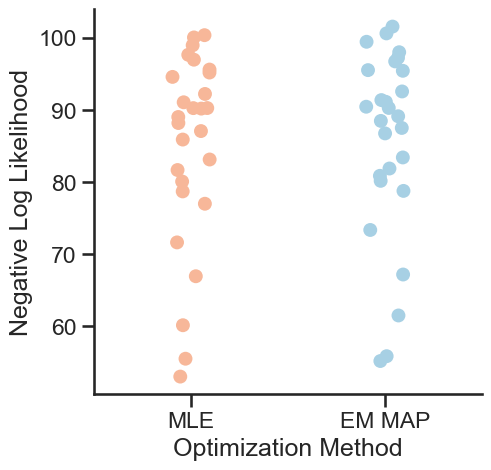

In [30]:
# negll comparisons 
    # heatmap - need to make grid of negll for risk & loss params -- later 

fig,ax = plt.subplots(figsize=(5,5))

sns.stripplot(
    data=negll_plot_data, x="method", y="negll", 
    alpha=1, legend=False, size=10, palette='RdBu'
)

plt.ylabel('Negative Log Likelihood')
plt.xlabel('Optimization Method')
sns.despine()


plt.savefig(f'{fig_dir}negll_mle_emmap_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 


In [31]:
bic_mle_cat = ['MLE']*len(pt_params_df)
bic_emmap_cat = ['EM MAP']*len(pt_params_df)
bic_cat = bic_mle_cat + bic_emmap_cat

bic_data = list(pt_params_df.bic_mle) + list(pt_params_df.bic_emmap)
# negll_mle_data


bic_plot_data = pd.DataFrame({'bic':bic_data,'method':bic_cat})
# bic_plot_data

In [39]:
print('MLE BIC Mean = ',np.mean(pt_params_df.bic_mle))

print('EM MAP BIC Mean = ',np.mean(pt_params_df.bic_emmap))

MLE BIC Mean =  184.68964126926113
EM MAP BIC Mean =  186.09664427141578


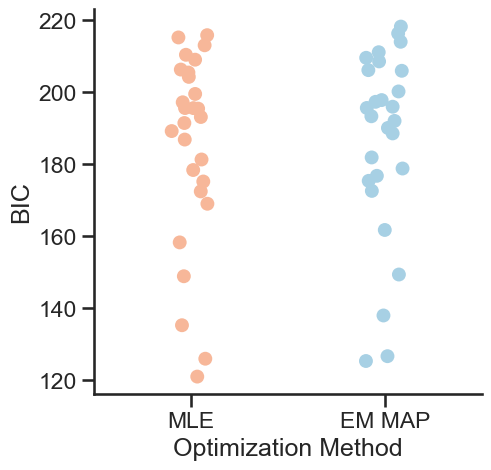

In [38]:
# bic comparisons 

fig,ax = plt.subplots(figsize=(5,5))

sns.stripplot(
    data=bic_plot_data, x="method", y="bic", 
    alpha=1, legend=False, size=10, palette='RdBu'
)

plt.ylabel('BIC')
plt.xlabel('Optimization Method')
sns.despine()


plt.savefig(f'{fig_dir}bic_mle_emmap_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

# GLMs


## Debugging GLM Fitting Functions

#### Create all subj model data df 

In [40]:
### load all subj data

master_subj_info = {}

for subj_id in subj_ids:
    #data loading
    task = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
    rate = pd.read_csv(f'{behav_dir}{subj_id}_rate_data')
    #gamble plot info
    loss,mix,gain = SWB_behav_utils.norm_gamble_choices(task)

    master_subj_info[subj_id] = {'task':task,'rate':rate,
                                 'loss':loss, 'mix':mix,'gain':gain
                                 }



In [41]:
model_data_vars = ['SafeBet','LowBet', 'HighBet',
       'GambleChoice', 'Outcome', 'Profit', 'TotalProfit', 'GambleEV', 'CR',
       'choiceEV', 'RPE', 'totalCPE', 'decisionCPE', 'totalRegret',
       'decisionRegret', 'totalRelief', 'decisionRelief', 'totalCF',
       'decisionCF', 'pRPE', 'nRPE', 'util_safe_mle', 'util_gamble_mle',
       'wSafe_mle', 'wHigh_mle', 'wLow_mle', 'p_safe_mle', 'p_gamble_mle',
       'util_safe_emmap', 'util_gamble_emmap', 'wSafe_emmap', 'wHigh_emmap',
       'wLow_emmap', 'p_safe_emmap', 'p_gamble_emmap', 'util_tCPE_mle',
       'util_dCPE_mle', 'util_tCF_mle', 'util_dCF_mle', 'util_tRegret_mle',
       'util_dRegret_mle', 'util_tRelief_mle', 'util_dRelief_mle',
       'util_RPE_mle', 'util_pRPE_mle', 'util_nRPE_mle', 'util_tCPE_emmap',
       'util_dCPE_emmap', 'util_tCF_emmap', 'util_dCF_emmap',
       'util_tRegret_emmap', 'util_dRegret_emmap', 'util_tRelief_emmap',
       'util_dRelief_emmap', 'util_RPE_emmap', 'util_pRPE_emmap',
       'util_nRPE_emmap']

In [42]:
# update model data here w pt 

all_subj_model_data = {} #make dictionary with keys as subjects names, each one containing a dictionary with keys that are column names for larger df 

model_data_keys = []
for var in model_data_vars:
    t1_col = var + '_t-1' 
    t2_col = var + '_t-2'
    t3_col = var + '_t-3'
    model_data_keys.append(t1_col)
    model_data_keys.append(t2_col)
    model_data_keys.append(t3_col)

#create model data pandas df with model_data_dict_keys as column names 
model_df_col_names = ['subj_id','round','rate','z_rate','bdi','bai'] + model_data_keys
all_subj_model_df = pd.DataFrame(columns = model_df_col_names)


for subj_id in subj_ids:
    subj_model_dict = SWB_modeling_utils.get_glm_data_single_subj(subj_id,behav_dir,model_data_vars)
    all_subj_model_data[subj_id] = subj_model_dict #in case dictionary of dictionaries is easier to work with later
    all_subj_model_df = pd.concat([all_subj_model_df,pd.DataFrame(subj_model_dict)])

all_subj_model_df.to_csv(f'{base_dir}swb_computational_modeling/swb_behav_models/data/glm_inputs/all_subj_model_df_{date}.csv')

## GLMs with Model-Free Parameter Inputs

### Base Models:
1) Base       (CR+EV)
2) RPE        (CR+EV+RPE)
3) nRPE       (CR+EV+nRPE)
4) pRPE       (CR+EV+pRPE)
5) nRPE_pRPE  (CR+EV+nRPE+pRPE)

8)  tCPE      (CR+EV+tCPE) 
9)  dCPE      (CR+EV+dCPE) 
10) RPE_tCPE  (CR+EV+RPE+tCPE)
11) RPE_dCPE  (CR+EV+RPE+dCPE)
12) tRegret   (CR+EV+tRegret)
13) dRegret   (CR+EV+dRegret)
14) tRelief   (CR+EV+tRelief)
15) dRelief   (CR+EV+dRelief)
16) nRPE_tReg (CR+EV+nRPE+tRegret)
17) nRPE_dReg (CR+EV+nRPE+dRegret)
18) pRPE_tRel (CR+EV+pRPE+tRelief)
19) pRPE_dRel (CR+EV+pRPE+dRelief)
20) nRPE_tReg_pRPE_tRel (CR+EV+nRPE+pRPE+tRegret+tRelief)
21) nRPE_dReg_pRPE_dRel (CR+EV+nRPE+pRPE+dRegret+dRelief)

### Utility Models: (EM MAP Fits)
22) Base_util      (util_s+util_g)
23) RPE_util       (util_s+util_g+util_RPE)
24) tCPE_util      (util_s+util_g+util_tCPE)
25) dCPE_util      (util_s+util_g+util_dCPE)
26) tCPE_RPE_util  (util_s+util_g+util_RPE+util_tCPE)
27) dCPE_RPE_util  (util_s+util_g+util_RPE+util_dCPE)
28) tRegret_util   (util_s+util_g+util_tRegret)
29) dRegret_util   (util_s+util_g+util_dRegret)
30) tRelief_util   (util_s+util_g+util_tRelief)
31) dRelief_util   (util_s+util_g+util_dRelief)
32) tReg_tRel_util (util_s+util_g+util_tRegret+util_tRelief)
33) dReg_dRel_util (util_s+util_g+util_dRegret+util_dRelief)
34) nRPE_tReg_util (util_s+util_g+util_nRPE+util_tRegret)
35) nRPE_dReg_util (util_s+util_g+util_nRPE+util_dRegret)
36) pRPE_tRel_util (util_s+util_g+util_pRPE+util_tRelief)
37) pRPE_dRel_util (util_s+util_g+util_pRPE+util_dRelief)
38) nRPE_pRPE_tReg_tRel_util (util_s+util_g+util_nRPE+util_pRPE+util_tRegret+util_tRelief)
39) nRPE_pRPE_dReg_dRel_util (util_s+util_g+util_nRPE+util_pRPE+util_dRegret+util_dRelief)

### Mixed Models:
40) Base_util_RPE        (util_s+util_g+RPE)
41) Base_util_nRPE       (util_s+util_g+nRPE)
42) Base_util_pRPE       (util_s+util_g+pRPE)
43) Base_util_tCPE       (util_s+util_g+tCPE)
44) Base_util_dCPE       (util_s+util_g+dCPE)
45) Base_util_tRegret    (util_s+util_g+tRegret)
46) Base_util_dRegret    (util_s+util_g+dRegret)
47) Base_util_tRelief    (util_s+util_g+tRelief)
48) Base_util_dRelief    (util_s+util_g+dRelief)
49) Base_util_RPE_tCPE   (util_s+util_g+RPE+tCPE)
50) Base_util_RPE_dCPE   (util_s+util_g+RPE+dCPE)
51) Base_util_tRegret_tRelief (util_s+util_g+tRegret+tRelief)
52) Base_util_dRegret_dRelief (util_s+util_g+dRegret+dRelief)
53) Base_util_nRPE_tRegret_pRPE_tRelief (util_s+util_g+nRPE+tRegret+pRPE+tRelief)
54) Base_util_nRPE_dRegret_pRPE_dRelief (util_s+util_g+nRPE+dRegret+pRPE+dRelief)

In [72]:
models_dict = {}
#base models 
models_dict['Base']                = ['CR','choiceEV']
models_dict['RPE']                 = ['CR','choiceEV','RPE']
models_dict['nRPE']                = ['CR','choiceEV','nRPE']
models_dict['pRPE']                = ['CR','choiceEV','pRPE']
models_dict['nRPE_pRPE']           = ['CR','choiceEV','nRPE','pRPE']
models_dict['tCPE']                = ['CR','choiceEV','totalCPE']
models_dict['dCPE']                = ['CR','choiceEV','decisionCPE']
models_dict['RPE_tCPE']            = ['CR','choiceEV','RPE','totalCPE']
models_dict['RPE_dCPE']            = ['CR','choiceEV','RPE','decisionCPE']
models_dict['tRegret']             = ['CR','choiceEV','totalRegret']
models_dict['dRegret']             = ['CR','choiceEV','decisionRegret']
models_dict['tRelief']             = ['CR','choiceEV','totalRelief']
models_dict['dRelief']             = ['CR','choiceEV','decisionRelief']
models_dict['nRPE_tReg']           = ['CR','choiceEV','nRPE','totalRegret']
models_dict['nRPE_dReg']           = ['CR','choiceEV','nRPE','decisionRegret']
models_dict['pRPE_tRel']           = ['CR','choiceEV','pRPE','totalRelief']
models_dict['pRPE_dRel']           = ['CR','choiceEV','pRPE','decisionRelief']
models_dict['nRPE_tReg_pRPE_tRel'] = ['CR','choiceEV','nRPE','totalRegret','pRPE','totalRelief']
models_dict['nRPE_dReg_pRPE_dRel'] = ['CR','choiceEV','nRPE','decisionRegret','pRPE','decisionRelief']
#utility models
models_dict['Base_util']                = ['util_safe_emmap','util_gamble_emmap']
models_dict['RPE_util']                 = ['util_safe_emmap','util_gamble_emmap','util_RPE_emmap']
models_dict['tCPE_util']                = ['util_safe_emmap','util_gamble_emmap','util_tCPE_emmap']
models_dict['dCPE_util']                = ['util_safe_emmap','util_gamble_emmap','util_dCPE_emmap']
models_dict['tCPE_RPE_util']            = ['util_safe_emmap','util_gamble_emmap','util_RPE_emmap','util_tCPE_emmap']
models_dict['dCPE_RPE_util']            = ['util_safe_emmap','util_gamble_emmap','util_RPE_emmap','util_dCPE_emmap']
models_dict['tRegret_util']             = ['util_safe_emmap','util_gamble_emmap','util_tRegret_emmap']
models_dict['dRegret_util']             = ['util_safe_emmap','util_gamble_emmap','util_dRegret_emmap']
models_dict['tRelief_util']             = ['util_safe_emmap','util_gamble_emmap','util_tRelief_emmap']
models_dict['dRelief_util']             = ['util_safe_emmap','util_gamble_emmap','util_dRelief_emmap']
models_dict['tReg_tRel_util']           = ['util_safe_emmap','util_gamble_emmap','util_tRegret_emmap','util_tRelief_emmap']
models_dict['dReg_dRel_util']           = ['util_safe_emmap','util_gamble_emmap','util_dRegret_emmap','util_dRelief_emmap']
models_dict['nRPE_tReg_util']           = ['util_safe_emmap','util_gamble_emmap','util_nRPE_emmap','util_tRegret_emmap']
models_dict['nRPE_dReg_util']           = ['util_safe_emmap','util_gamble_emmap','util_nRPE_emmap','util_dRegret_emmap']
models_dict['pRPE_tRel_util']           = ['util_safe_emmap','util_gamble_emmap','util_pRPE_emmap','util_tRelief_emmap']
models_dict['pRPE_dRel_util']           = ['util_safe_emmap','util_gamble_emmap','util_pRPE_emmap','util_dRelief_emmap']
models_dict['nRPE_tReg_pRPE_tRel_util'] = ['util_safe_emmap','util_gamble_emmap','util_nRPE_emmap','util_tRegret_emmap','util_pRPE_emmap','util_tRelief_emmap']
models_dict['nRPE_dReg_pRPE_dRel_util'] = ['util_safe_emmap','util_gamble_emmap','util_nRPE_emmap','util_dRegret_emmap','util_pRPE_emmap','util_dRelief_emmap']
#mixed models
models_dict['Base_util_RPE']                       = ['util_safe_emmap','util_gamble_emmap','RPE']
models_dict['Base_util_nRPE']                      = ['util_safe_emmap','util_gamble_emmap','nRPE']
models_dict['Base_util_pRPE']                      = ['util_safe_emmap','util_gamble_emmap','pRPE']
models_dict['Base_util_tCPE']                      = ['util_safe_emmap','util_gamble_emmap','totalCPE']
models_dict['Base_util_dCPE']                      = ['util_safe_emmap','util_gamble_emmap','decisionCPE']
models_dict['Base_util_tRegret']                   = ['util_safe_emmap','util_gamble_emmap','totalRegret']
models_dict['Base_util_dRegret']                   = ['util_safe_emmap','util_gamble_emmap','decisionRegret']
models_dict['Base_util_tRelief']                   = ['util_safe_emmap','util_gamble_emmap','totalRelief']
models_dict['Base_util_dRelief']                   = ['util_safe_emmap','util_gamble_emmap','decisionRelief']
models_dict['Base_util_RPE_tCPE']                  = ['util_safe_emmap','util_gamble_emmap','RPE','totalCPE']
models_dict['Base_util_RPE_dCPE']                  = ['util_safe_emmap','util_gamble_emmap','RPE','decisionCPE']
models_dict['Base_util_tRegret_tRelief']           = ['util_safe_emmap','util_gamble_emmap','totalRegret','totalRelief']
models_dict['Base_util_dRegret_dRelief']           = ['util_safe_emmap','util_gamble_emmap','decisionRegret','decisionRelief']
models_dict['Base_util_nRPE_tRegret_pRPE_tRelief'] = ['util_safe_emmap','util_gamble_emmap','nRPE','totalRegret','pRPE','totalRelief']
models_dict['Base_util_nRPE_dRegret_pRPE_dRelief'] = ['util_safe_emmap','util_gamble_emmap','nRPE','decisionRegret','pRPE','decisionRelief']


In [73]:
models_dict.keys()

dict_keys(['Base', 'RPE', 'nRPE', 'pRPE', 'nRPE_pRPE', 'tCPE', 'dCPE', 'RPE_tCPE', 'RPE_dCPE', 'tRegret', 'dRegret', 'tRelief', 'dRelief', 'nRPE_tReg', 'nRPE_dReg', 'pRPE_tRel', 'pRPE_dRel', 'nRPE_tReg_pRPE_tRel', 'nRPE_dReg_pRPE_dRel', 'Base_util', 'RPE_util', 'tCPE_util', 'dCPE_util', 'tCPE_RPE_util', 'dCPE_RPE_util', 'tRegret_util', 'dRegret_util', 'tRelief_util', 'dRelief_util', 'tReg_tRel_util', 'dReg_dRel_util', 'nRPE_tReg_util', 'nRPE_dReg_util', 'pRPE_tRel_util', 'pRPE_dRel_util', 'nRPE_tReg_pRPE_tRel_util', 'nRPE_dReg_pRPE_dRel_util', 'Base_util_RPE', 'Base_util_nRPE', 'Base_util_pRPE', 'Base_util_tCPE', 'Base_util_dCPE', 'Base_util_tRegret', 'Base_util_dRegret', 'Base_util_tRelief', 'Base_util_dRelief', 'Base_util_RPE_tCPE', 'Base_util_RPE_dCPE', 'Base_util_tRegret_tRelief', 'Base_util_dRegret_dRelief', 'Base_util_nRPE_tRegret_pRPE_tRelief', 'Base_util_nRPE_dRegret_pRPE_dRelief'])

# Run All Models

In [74]:
# create list of all regressors in model data for each variable (t-1,t-2,t-3)
model_vars = {}

for model in models_dict.keys():
    model_regs = models_dict[model]
    full_var_list = []
    for var in model_regs:
        t1_col = var + '_t-1' 
        t2_col = var + '_t-2'
        t3_col = var + '_t-3'
        # add modified variable names to list - should match column names in all_subj_model_df
        full_var_list.append(t1_col)
        full_var_list.append(t2_col)
        full_var_list.append(t3_col)
    model_vars[model] = full_var_list


In [75]:
model_vars.keys()

dict_keys(['Base', 'RPE', 'nRPE', 'pRPE', 'nRPE_pRPE', 'tCPE', 'dCPE', 'RPE_tCPE', 'RPE_dCPE', 'tRegret', 'dRegret', 'tRelief', 'dRelief', 'nRPE_tReg', 'nRPE_dReg', 'pRPE_tRel', 'pRPE_dRel', 'nRPE_tReg_pRPE_tRel', 'nRPE_dReg_pRPE_dRel', 'Base_util', 'RPE_util', 'tCPE_util', 'dCPE_util', 'tCPE_RPE_util', 'dCPE_RPE_util', 'tRegret_util', 'dRegret_util', 'tRelief_util', 'dRelief_util', 'tReg_tRel_util', 'dReg_dRel_util', 'nRPE_tReg_util', 'nRPE_dReg_util', 'pRPE_tRel_util', 'pRPE_dRel_util', 'nRPE_tReg_pRPE_tRel_util', 'nRPE_dReg_pRPE_dRel_util', 'Base_util_RPE', 'Base_util_nRPE', 'Base_util_pRPE', 'Base_util_tCPE', 'Base_util_dCPE', 'Base_util_tRegret', 'Base_util_dRegret', 'Base_util_tRelief', 'Base_util_dRelief', 'Base_util_RPE_tCPE', 'Base_util_RPE_dCPE', 'Base_util_tRegret_tRelief', 'Base_util_dRegret_dRelief', 'Base_util_nRPE_tRegret_pRPE_tRelief', 'Base_util_nRPE_dRegret_pRPE_dRelief'])

In [134]:
good_subj_list = ['DA8','DA9', 'DA10','DA11','DA023','MS001','MS002','MS003','MS004','MS009','MS011',
                  'MS015','MS016','MS017','MS019','MS020','MS022','MS024','MS025','MS026','MS027',
                  'MS029','MS030','MS033','MS035']

In [135]:
#rerun model with lam bounds fixed - lower bound = 0.001 not zero!
all_models = list(model_vars.keys())
swb_model_fit_dict = {}

for model_name in all_models:
    #get model regressor info
    n_regs = len(models_dict[model_name])
    full_reg_list = model_vars[model_name]
    # create random param_inits for minimization
    n_inits = 100 # number of minimization iterations (100 took 45min)
    param_inits = []
    for n in range(n_inits):
        lambda_init = random.uniform(0, 1)
        betas_init = np.random.random(size = (n_regs+1))
        param_inits.append(np.hstack((lambda_init,betas_init)))
    #iterate through subjects using same initial parameters
    all_subj_fit_info = {}
    for subj_id in good_subj_list:
        subj_df = all_subj_model_df[all_subj_model_df.subj_id==subj_id]
        subj_model_info = SWB_modeling_utils.min_rss_swb(subj_df,n_regs,full_reg_list,param_inits)
        all_subj_fit_info[subj_id] = subj_model_info
    swb_model_fit_dict[model_name] = all_subj_fit_info


36.561410206576994
36.561410206577754
36.56141021023964
36.56141020683347
36.56141020668728
36.561410206809086
36.56141020672475
36.56141020657886
36.56141020680441
36.56141020657761
36.56141020659179
36.56141020659191
36.561410206656355
36.56141020694886
36.56141020691181
36.561410206888695
36.5614102066016
36.56141020657782
36.561410206580554
36.5614102070468
36.56141020758331
36.56141020658859
36.56141020672241
36.5614102065797
36.56141020658019
36.56141020659108
36.56141020660213
36.561410215507884
36.56141020673475
36.561410236183896
36.56141020661173
36.561410210317256
36.56141020667044
36.561410206602076
36.56141020658393
36.56141020659468
36.56141020660093
36.56141020663009
36.56141020672843
36.561410206859264
36.56141020657815
36.561410206763156
36.561410206577456
36.56141020686928
36.56141020657762
36.56141020657946
36.56141020658045
36.56141020661738
36.5614102093973
36.561410206904675
36.56141020666047
36.5614102073591
36.56141020663326
36.561410206577285
36.56141020660769


In [137]:
swb_model_fit_dict.keys()

dict_keys(['Base', 'RPE', 'nRPE', 'pRPE', 'nRPE_pRPE', 'tCPE', 'dCPE', 'RPE_tCPE', 'RPE_dCPE', 'tRegret', 'dRegret', 'tRelief', 'dRelief', 'nRPE_tReg', 'nRPE_dReg', 'pRPE_tRel', 'pRPE_dRel', 'nRPE_tReg_pRPE_tRel', 'nRPE_dReg_pRPE_dRel', 'Base_util', 'RPE_util', 'tCPE_util', 'dCPE_util', 'tCPE_RPE_util', 'dCPE_RPE_util', 'tRegret_util', 'dRegret_util', 'tRelief_util', 'dRelief_util', 'tReg_tRel_util', 'dReg_dRel_util', 'nRPE_tReg_util', 'nRPE_dReg_util', 'pRPE_tRel_util', 'pRPE_dRel_util', 'nRPE_tReg_pRPE_tRel_util', 'nRPE_dReg_pRPE_dRel_util', 'Base_util_RPE', 'Base_util_nRPE', 'Base_util_pRPE', 'Base_util_tCPE', 'Base_util_dCPE', 'Base_util_tRegret', 'Base_util_dRegret', 'Base_util_tRelief', 'Base_util_dRelief', 'Base_util_RPE_tCPE', 'Base_util_RPE_dCPE', 'Base_util_tRegret_tRelief', 'Base_util_dRegret_dRelief', 'Base_util_nRPE_tRegret_pRPE_tRelief', 'Base_util_nRPE_dRegret_pRPE_dRelief'])

In [138]:
subj_df

subj_id round  rate    z_rate bdi bai  SafeBet_t-1  SafeBet_t-2  \
2    MS035     4  58.0  0.574319  15  10          0.3         -0.5   
3    MS035     7  58.0  0.574319  15  10         -0.4          0.4   
4    MS035    10  39.0 -0.482342  15  10         -0.6          0.0   
5    MS035    13  72.0  1.352911  15  10          0.0         -0.3   
6    MS035    16  62.0  0.796774  15  10          0.0          0.2   
7    MS035    19  61.0  0.741160  15  10          0.0         -0.5   
8    MS035    22  34.0 -0.760411  15  10          0.3         -0.2   
9    MS035    25  36.0 -0.649183  15  10          0.0          0.2   
10   MS035    28  41.0 -0.371115  15  10          0.6         -0.4   
11   MS035    31  64.0  0.908001  15  10         -0.4          0.5   
12   MS035    34  37.0 -0.593570  15  10          0.6          0.2   
13   MS035    37  37.0 -0.593570  15  10         -0.2         -0.4   
14   MS035    40  33.0 -0.816025  15  10          0.0         -0.5   
15   MS035    43  69.0  1.186070  15  10          0.0          0.0   
16   MS035    46  68.0  1.130456  15  10          0.2          0.0   
17   MS035    49  70.0  1.241684  15  10          0.0          0.0   
18   MS035    52  32.0 -0.871638  15  10          0.0          0.3   
19   MS035    55  30.0 -0.982866  15  10          0.0          0.6   
20   MS035    58  34.0 -0.760411  15  10          0.0          0.0   
21   MS035    61  31.0 -0.927252  15  10          0.0         -0.2   
22   MS035    64  34.0 -0.760411  15  10          0.4         -0.3   
23   MS035    67  28.0 -1.094093  15  10          0.0          0.2   
24   MS035    70  66.0  1.019229  15  10          0.0          0.0   
25   MS035    73  26.0 -1.205321  15  10          0.0          0.0   
26   MS035    76  24.0 -1.316548  15  10          0.3         -0.2   
27   MS035    79  55.0  0.407478  15  10         -0.6          0.0   
28   MS035    82  25.0 -1.260935  15  10          0.4         -0.3   
29   MS035    85  63.0  0.852388  15  10          0.3          0.3   
30   MS035    88  33.0 -0.816025  15  10         -0.3         -0.4   
31   MS035    91  33.0 -0.816025  15  10         -0.3          0.6   
32   MS035    94  56.0  0.463091  15  10          0.5          0.2   
33   MS035    97  61.0  0.741160  15  10          0.2          0.0   
34   MS035   100  39.0 -0.482342  15  10          0.4          0.6   
35   MS035   103  25.0 -1.260935  15  10         -0.2          0.6   
36   MS035   106  44.0 -0.204274  15  10          0.4          0.5   
37   MS035   109  32.0 -0.871638  15  10         -0.3          0.0   
38   MS035   112  21.0 -1.483390  15  10          0.0          0.0   
39   MS035   115  60.0  0.685546  15  10          0.4          0.2   
40   MS035   118  77.0  1.630980  15  10          0.0         -0.2   
41   MS035   121  67.0  1.074842  15  10         -0.6         -0.5   
42   MS035   124  72.0  1.352911  15  10          0.3          0.0   
43   MS035   127  72.0  1.352911  15  10          0.0          0.6   
44   MS035   130  36.0 -0.649183  15  10          0.0          0.0   
45   MS035   133  29.0 -1.038480  15  10          0.0         -0.2   
46   MS035   136  36.0 -0.649183  15  10          0.0          0.6   
47   MS035   139  77.0  1.630980  15  10          0.0          0.5   
48   MS035   142  76.0  1.575366  15  10         -0.6         -0.3   
49   MS035   145  26.0 -1.205321  15  10         -0.3         -0.6   
50   MS035   148  29.0 -1.038480  15  10          0.0          0.2   
51   MS035   151  76.0  1.575366  15  10         -0.5         -0.4   

    SafeBet_t-3  LowBet_t-1  ...  util_dRelief_emmap_t-3  util_RPE_emmap_t-1  \
2           0.0        0.00  ...                0.000000           -0.772217   
3          -0.6       -1.68  ...                0.388010            0.600692   
4          -0.6       -1.68  ...                0.000000            0.600692   
5           0.2       -0.80  ...                0.236643            0.271165   
6           0.0       -1.10  ...

In [139]:
#### save estimation dict 
save_dir = f'{base_dir}swb_computational_modeling/swb_behav_models/data/glm_data/'
os.makedirs(save_dir,exist_ok = True) 
date = datetime.date.today().strftime('%m%d%Y')

# create a binary pickle file 
f = open(f'{save_dir}swb_glm_fit_dict_{date}.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(swb_model_fit_dict,f)
# # close file
f.close()

In [85]:
swb_model_fit_dict.keys()

dict_keys(['Base', 'RPE', 'nRPE', 'pRPE', 'nRPE_pRPE', 'EV_RPE', 'CR_RPE', 'tCPE', 'dCPE', 'RPE_tCPE', 'RPE_dCPE', 'tRegret', 'dRegret', 'tRelief', 'dRelief', 'nRPE_tReg', 'nRPE_dReg', 'pRPE_tRel', 'pRPE_dRel', 'nRPE_tReg_pRPE_tRel', 'nRPE_dReg_pRPE_dRel', 'Base_util', 'RPE_util', 'tCPE_util', 'dCPE_util', 'tCPE_RPE_util', 'dCPE_RPE_util', 'tRegret_util', 'dRegret_util', 'tRelief_util', 'dRelief_util', 'tReg_tRel_util', 'dReg_dRel_util', 'nRPE_tReg_util', 'nRPE_dReg_util', 'pRPE_tRel_util', 'pRPE_dRel_util', 'nRPE_pRPE_tReg_tRel_util', 'nRPE_pRPE_dReg_dRel_util', 'Base_util_RPE', 'Base_util_nRPE', 'Base_util_pRPE', 'Base_util_tCPE', 'Base_util_dCPE', 'Base_util_tRegret', 'Base_util_dRegret', 'Base_util_tRelief', 'Base_util_dRelief', 'Base_util_RPE_tCPE', 'Base_util_RPE_dCPE', 'Base_util_tRegret_tRelief', 'Base_util_dRegret_dRelief', 'Base_util_nRPE_tRegret_pRPE_tRelief', 'Base_util_nRPE_dRegret_pRPE_dRelief', 'nRPE_tReg_pRPE_tRel_util', 'nRPE_dReg_pRPE_dRel_util'])

In [141]:
# extract model results from swb_model_fit_dict
    # for each model - make df: cols = subj_ids, lam_est, b_int, b_reg1... b_regX, BIC, AIC, RSS

all_results_dict = {} # list of model results dfs for each glm 

for model_name in swb_model_fit_dict.keys():
    # swb_model_fit_dict > model name > subj dicts > best_result & subj_dict
    model_outputs = swb_model_fit_dict[model_name]
    # get regressor names & add lam, beta intercept to list 
    model_param_ids = ['lam','beta_int'] + models_dict[model_name]
    #create model df for all subj with col names:
    model_results_df_cols = ['subj_id','bic','aic','rss'] + model_param_ids
    model_results_df = pd.DataFrame(columns = model_results_df_cols)
    
    for ix,subj_id in enumerate(good_subj_list):
        model_subj_dict = model_outputs[subj_id]['subj_dict']
        
        #add subj_id, bic, aic, rss to df 
        subj_save_dict = {}
        subj_save_dict['subj_id']  = [subj_id]
        subj_save_dict['bic']      = model_subj_dict['bic']
        subj_save_dict['aic']      = model_subj_dict['aic']
        subj_save_dict['rss']      = model_subj_dict['rss']

        # extract param est 
        subj_param_est = model_subj_dict['params']
        # match param_est to column name & add to df 
        for param_est,param_id in list(zip(subj_param_est,model_param_ids)):
            #add param_est to df using param_id column name and subj row idx
            subj_save_dict[param_id] = param_est
        
        subj_df = pd.DataFrame(subj_save_dict)
        model_results_df = pd.concat([model_results_df,subj_df])
        
    
    #add model_results_df to all_results_dict of model
    all_results_dict[model_name] = model_results_df
            
all_results_dict

{'Base':   subj_id        bic       aic        rss       lam  beta_int        CR  \
 0     DA8  16.152935  7.707173  36.561410  0.409523 -0.393192 -0.871182   
 0     DA9  17.868648  6.849316  15.504600  1.000000 -0.414895 -0.517055   
 0    DA10  16.313056  7.627112  33.748392  0.445240  0.024324  1.206436   
 0    DA11  16.953757  7.347167  26.028454  0.001000  0.075427  0.786873   
 0   DA023  16.004281  7.781500  39.382449  0.001000 -0.016120  0.376194   
 0   MS001  15.916355  7.865869  43.723764  0.001000  0.020126 -0.463299   
 0   MS002  15.876516  7.845383  41.980410  1.000000 -0.011833 -0.136606   
 0   MS003  16.566449  7.500416  29.732376  1.000000 -0.136967  0.382306   
 0   MS004  16.092582  7.777755  40.035965  0.884279 -0.003244  0.672333   
 0   MS009  15.694806  7.936237  45.973162  1.000000  0.059635  0.246158   
 0   MS011  15.671238  7.948021  46.518112  0.207417  0.132782  0.910811   
 0   MS015  15.756019  7.905631  44.587395  0.887717 -0.018712  0.321331   
 0  

In [142]:
#### save estimation dict 
save_dir = f'{base_dir}swb_computational_modeling/swb_behav_models/data/glm_data/'
os.makedirs(save_dir,exist_ok = True) 
date = datetime.date.today().strftime('%m%d%Y')

# create a binary pickle file 
f = open(f'{save_dir}glm_results_dfs_dict_{date}.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(all_results_dict,f)
# # close file
f.close()

In [143]:
all_results_dict.keys()

dict_keys(['Base', 'RPE', 'nRPE', 'pRPE', 'nRPE_pRPE', 'tCPE', 'dCPE', 'RPE_tCPE', 'RPE_dCPE', 'tRegret', 'dRegret', 'tRelief', 'dRelief', 'nRPE_tReg', 'nRPE_dReg', 'pRPE_tRel', 'pRPE_dRel', 'nRPE_tReg_pRPE_tRel', 'nRPE_dReg_pRPE_dRel', 'Base_util', 'RPE_util', 'tCPE_util', 'dCPE_util', 'tCPE_RPE_util', 'dCPE_RPE_util', 'tRegret_util', 'dRegret_util', 'tRelief_util', 'dRelief_util', 'tReg_tRel_util', 'dReg_dRel_util', 'nRPE_tReg_util', 'nRPE_dReg_util', 'pRPE_tRel_util', 'pRPE_dRel_util', 'nRPE_tReg_pRPE_tRel_util', 'nRPE_dReg_pRPE_dRel_util', 'Base_util_RPE', 'Base_util_nRPE', 'Base_util_pRPE', 'Base_util_tCPE', 'Base_util_dCPE', 'Base_util_tRegret', 'Base_util_dRegret', 'Base_util_tRelief', 'Base_util_dRelief', 'Base_util_RPE_tCPE', 'Base_util_RPE_dCPE', 'Base_util_tRegret_tRelief', 'Base_util_dRegret_dRelief', 'Base_util_nRPE_tRegret_pRPE_tRelief', 'Base_util_nRPE_dRegret_pRPE_dRelief'])

In [145]:
all_results_dict['RPE']
# np.mean(all_results_dict['EV_RPE'].bic)

subj_id        bic       aic        rss       lam  beta_int        CR  \
0     DA8  20.299983  9.159119  32.181109  0.474558 -0.249377 -0.650412   
0     DA9  22.376918  7.082183  11.392006  0.379996 -0.132499 -0.563444   
0    DA10  20.989675  8.469427  22.794830  0.469223 -0.009708  0.957867   
0    DA11  21.110252  8.449863  23.033614  0.001000  0.051034  0.776336   
0   DA023  19.900808  9.558293  39.289874  0.001000 -0.016365  0.375554   
0   MS001  20.061604  9.498512  38.911069  0.001000 -0.057276 -0.479002   
0   MS002  19.822661  9.636441  40.855472  1.000000 -0.025165 -0.127386   
0   MS003  20.552923  8.906178  28.358004  1.000000 -0.136861  0.411082   
0   MS004  21.017359  8.542756  24.128681  0.713212  0.013633  0.730173   
0   MS009  19.597236  9.861866  45.729942  0.075893  0.006773 -0.357556   
0   MS011  19.813571  9.645530  41.041564  0.497128  0.168071  0.899288   
0   MS015  19.691035  9.768066  43.634732  1.000000  0.002687  0.298137   
0   MS016  21.618161  7.840941  16.648012  0.558993 -0.126547  0.072191   
0   MS017  20.363641  9.095461  31.172947  0.500367  0.173314  1.027474   
0   MS019  19.983566  9.475536  37.697289  0.001000  0.138729 -5.333913   
0   MS020  19.745257  9.713844  42.467638  1.000000 -0.060244 -0.080375   
0   MS022  19.860863  9.598238  40.082485  0.001000 -0.109179 -0.071584   
0   MS024  20.146598  9.312503  34.746261  0.001000  0.002667  0.858289   
0   MS025  20.720936  8.738166  26.073078  0.918835  0.016606  1.189080   
0   MS026  19.766282  9.692819  42.023535  0.302037  0.214129  1.162006   
0   MS027  21.999159  7.459943  13.760357  0.316154  0.062937 -0.235558   
0   MS029  20.389857  9.069245  30.767002  0.881131  0.073897  0.914355   
0   MS030  24.894101  4.565000   3.235943  0.001000  0.142669  0.236935   
0   MS033  21.004441  8.454661  22.627156  0.209515 -0.266148 -1.670501   
0   MS035  20.478157  9.081958  31.595103  0.152071  0.057074 -0.118628   

   choiceEV       RPE  
0  0.973808  1.019433  
0  0.890418  0.723955  
0  0.609556  0.837429  
0  0.670485  0.536726  
0  0.592981  0.084611  
0  0.459243  0.448227  
0  0.406446  0.185755  
0  0.277576  0.155339  
0  0.781738  1.055463  
0  0.116299  0.298601  
0 -0.096810  0.615707  
0 -0.363181  0.131293  
0  0.310748  0.401611  
0  0.006121  0.780234  
0  0.257825  0.416946  
0  0.374252  0.498703  
0  0.630144  0.519784  
0 -0.338957  0.911858  
0  0.483766  0.797437  
0 -0.187119  0.471122  
0  0.401186  0.002068  
0  0.644414  0.116713  
0 -0.015280 -0.153089  
0  0.727268  0.326035  
0  0.587711  1.224339

In [146]:
# summary stats of model results 

all_results_summary_dict = {}

for model_name in all_results_dict.keys():
    model_df = all_results_dict[model_name]
    model_summary_dict = {}
    model_summary_dict['bic'] = np.mean(all_results_dict[model_name].bic)
    model_summary_dict['bic_sum'] = np.sum(all_results_dict[model_name].bic)
    model_summary_dict['aic'] = np.mean(all_results_dict[model_name].aic)
    model_summary_dict['aic_sum'] = np.sum(all_results_dict[model_name].aic)
    model_summary_dict['rss'] = np.mean(all_results_dict[model_name].rss)
    model_summary_dict['rss_sum'] = np.sum(all_results_dict[model_name].rss)
    model_param_ids = ['lam','beta_int'] + models_dict[model_name]
    for param_id in model_param_ids:
        model_summary_dict[param_id] = np.mean(all_results_dict[model_name][param_id])

    all_results_summary_dict[model_name] = model_summary_dict

    

In [147]:
all_results_summary_dict

{'Base': {'bic': 16.46859528736857,
  'bic_sum': 411.7148821842142,
  'aic': 7.555807818878576,
  'aic_sum': 188.8951954719644,
  'rss': 35.046262438235104,
  'rss_sum': 876.1565609558776,
  'lam': 0.45001439544637833,
  'beta_int': -0.013431823510978238,
  'CR': 0.022601609160531062,
  'choiceEV': 0.30412866646717895},
 'RPE': {'bic': 20.64820167231214,
  'bic_sum': 516.2050418078035,
  'aic': 8.827061984095009,
  'aic_sum': 220.67654960237522,
  'rss': 30.56990814622144,
  'rss_sum': 764.247703655536,
  'lam': 0.4182444505192753,
  'beta_int': -0.002605931245686314,
  'CR': 0.008816304176862053,
  'choiceEV': 0.3680255760611888,
  'RPE': 0.49625212203685704},
 'nRPE': {'bic': 20.58649740248726,
  'bic_sum': 514.6624350621815,
  'aic': 8.888766253919883,
  'aic_sum': 222.21915634799706,
  'rss': 31.195172737902546,
  'rss_sum': 779.8793184475636,
  'lam': 0.48367925117874017,
  'beta_int': 0.17154727456637697,
  'CR': 0.059662631047797364,
  'choiceEV': 0.4150219263460629,
  'nRPE': 0

In [148]:
model_names_list = list(all_results_summary_dict.keys())
bic_list         = []
aic_list         = []
rss_list         = []
bic_sum          = []
aic_sum          = []
rss_sum          = []
param_num_list   = []

for model_name in all_results_summary_dict.keys():
    model_summary = all_results_summary_dict[model_name]
    bic_list.append(model_summary['bic'])
    bic_sum.append(model_summary['bic_sum'])
    aic_list.append(model_summary['aic'])
    aic_sum.append(model_summary['aic_sum'])
    rss_list.append(model_summary['rss'])
    rss_sum.append(model_summary['rss_sum'])
    param_num_list.append(len(model_summary)-3)

In [149]:
all_results_df = pd.DataFrame({'model_name':model_names_list,'bic_mean':bic_list,'bic_sum':bic_sum,
                               'aic_mean':aic_list,'aic_sum':aic_sum,'rss_mean':rss_list,'rss_sum':rss_sum,'n_params':param_num_list})

all_results_df.to_csv(f'{base_dir}swb_computational_modeling/swb_behav_models/data/glm_data/glm_summary_df_{date}.csv')


In [150]:
all_results_df

model_name   bic_mean     bic_sum   aic_mean  \
0                                  Base  16.468595  411.714882   7.555808   
1                                   RPE  20.648202  516.205042   8.827062   
2                                  nRPE  20.586497  514.662435   8.888766   
3                                  pRPE  20.533527  513.338167   8.941737   
4                             nRPE_pRPE  24.597324  614.933090  10.159489   
5                                  tCPE  20.651759  516.293965   8.823505   
6                                  dCPE  20.590419  514.760481   8.884844   
7                              RPE_tCPE  24.619323  615.483063  10.126491   
8                              RPE_dCPE  24.615531  615.388272  10.132178   
9                               tRegret  20.590319  514.757965   8.884945   
10                              dRegret  20.547478  513.686959   8.927785   
11                              tRelief  20.584500  514.612490   8.890764   
12                              dRelief  20.543384  513.584590   8.931880   
13                            nRPE_tReg  24.554818  613.870459  10.223247   
14                            nRPE_dReg  24.560580  614.014501  10.214605   
15                            pRPE_tRel  24.537378  613.434458  10.249407   
16                            pRPE_dRel  24.524530  613.113259  10.268679   
17                  nRPE_tReg_pRPE_tRel  32.517092  812.927294  12.608325   
18                  nRPE_dReg_pRPE_dRel  32.513103  812.827568  12.618298   
19                            Base_util  16.433937  410.848429   7.573137   
20                             RPE_util  20.506167  512.654165   8.969097   
21                            tCPE_util  20.619803  515.495087   8.855460   
22                            dCPE_util  20.546060  513.651490   8.929204   
23                        tCPE_RPE_util  24.570009  614.250220  10.200461   
24                        dCPE_RPE_util  24.521182  613.029553  10.273701   
25                         tRegret_util  20.590289  514.757217   8.884975   
26                         dRegret_util  20.497616  512.440400   8.977648   
27                         tRelief_util  20.548686  513.717152   8.926578   
28                         dRelief_util  20.514144  512.853599   8.961120   
29                       tReg_tRel_util  24.612561  615.314024  10.136633   
30                       dReg_dRel_util  24.530006  613.250160  10.260465   
31                       nRPE_tReg_util  24.560533  614.013334  10.214675   
32                       nRPE_dReg_util  24.459014  611.475355  10.366953   
33                       pRPE_tRel_util  24.499827  612.495680  10.305734   
34                       pRPE_dRel_util  24.467071  611.676782  10.354868   
35             nRPE_tReg_pRPE_tRel_util  32.520793  813.019817  12.599073   
36             nRPE_dReg_pRPE_dRel_util  32.452581  811.314524  12.769602   
37                        Base_util_RPE  20.651266  516.281644   8.823998   
38                       Base_util_nRPE  20.586196  514.654900   8.889068   
39                       Base_util_pRPE  20.526434  513.160850   8.948830   
40                       Base_util_tCPE  20.672506  516.812662   8.802757   
41                       Base_util_dCPE  20.609142  515.228559   8.866121   
42                    Base_util_tRegret  20.587559  514.688966   8.887705   
43                    Base_util_dRegret  20.540722  513.518042   8.934542   
44                    Base_util_tRelief  20.612271  515.306783   8.862992   
45                    Base_util_dRelief  20.573159  514.328964   8.902105   
46                   Base_util_RPE_tCPE  24.642939  616.073485  10.091065   
47                   Base_util_RPE_dCPE  24.642316  616.057898  10.092001   
48            Base_util_tRegret_tRelief  24.626431  615.660764  10.115829   
49            Base_util_dRegret_dRelief  24.573222  614.330549  10.195642   
50  Base_util_nRPE_tRegret_pRPE_tRelief  32.547569  813.689235  12.532131   
51  Base_util_nRPE_dRegre

In [151]:
# find best models 
sorted_results_df = all_results_df.sort_values('bic_mean')
sorted_results_df

model_name   bic_mean     bic_sum   aic_mean  \
19                            Base_util  16.433937  410.848429   7.573137   
0                                  Base  16.468595  411.714882   7.555808   
26                         dRegret_util  20.497616  512.440400   8.977648   
20                             RPE_util  20.506167  512.654165   8.969097   
28                         dRelief_util  20.514144  512.853599   8.961120   
39                       Base_util_pRPE  20.526434  513.160850   8.948830   
3                                  pRPE  20.533527  513.338167   8.941737   
43                    Base_util_dRegret  20.540722  513.518042   8.934542   
12                              dRelief  20.543384  513.584590   8.931880   
22                            dCPE_util  20.546060  513.651490   8.929204   
10                              dRegret  20.547478  513.686959   8.927785   
27                         tRelief_util  20.548686  513.717152   8.926578   
45                    Base_util_dRelief  20.573159  514.328964   8.902105   
11                              tRelief  20.584500  514.612490   8.890764   
38                       Base_util_nRPE  20.586196  514.654900   8.889068   
2                                  nRPE  20.586497  514.662435   8.888766   
42                    Base_util_tRegret  20.587559  514.688966   8.887705   
25                         tRegret_util  20.590289  514.757217   8.884975   
9                               tRegret  20.590319  514.757965   8.884945   
6                                  dCPE  20.590419  514.760481   8.884844   
41                       Base_util_dCPE  20.609142  515.228559   8.866121   
44                    Base_util_tRelief  20.612271  515.306783   8.862992   
21                            tCPE_util  20.619803  515.495087   8.855460   
1                                   RPE  20.648202  516.205042   8.827062   
37                        Base_util_RPE  20.651266  516.281644   8.823998   
5                                  tCPE  20.651759  516.293965   8.823505   
40                       Base_util_tCPE  20.672506  516.812662   8.802757   
32                       nRPE_dReg_util  24.459014  611.475355  10.366953   
34                       pRPE_dRel_util  24.467071  611.676782  10.354868   
33                       pRPE_tRel_util  24.499827  612.495680  10.305734   
24                        dCPE_RPE_util  24.521182  613.029553  10.273701   
16                            pRPE_dRel  24.524530  613.113259  10.268679   
30                       dReg_dRel_util  24.530006  613.250160  10.260465   
15                            pRPE_tRel  24.537378  613.434458  10.249407   
13                            nRPE_tReg  24.554818  613.870459  10.223247   
31                       nRPE_tReg_util  24.560533  614.013334  10.214675   
14                            nRPE_dReg  24.560580  614.014501  10.214605   
23                        tCPE_RPE_util  24.570009  614.250220  10.200461   
49            Base_util_dRegret_dRelief  24.573222  614.330549  10.195642   
4                             nRPE_pRPE  24.597324  614.933090  10.159489   
29                       tReg_tRel_util  24.612561  615.314024  10.136633   
8                              RPE_dCPE  24.615531  615.388272  10.132178   
7                              RPE_tCPE  24.619323  615.483063  10.126491   
48            Base_util_tRegret_tRelief  24.626431  615.660764  10.115829   
47                   Base_util_RPE_dCPE  24.642316  616.057898  10.092001   
46                   Base_util_RPE_tCPE  24.642939  616.073485  10.091065   
36             nRPE_dReg_pRPE_dRel_util  32.452581  811.314524  12.769602   
18                  nRPE_dReg_pRPE_dRel  32.513103  812.827568  12.618298   
17                  nRPE_tReg_pRPE_tRel  32.517092  812.927294  12.608325   
35             nRPE_tReg_pRPE_tRel_util  32.520793  813.019817  12.599073   
51  Base_util_nRPE_dRegret_pRPE_dRelief  32.541204  813.530092  12.548045   
50  Base_util_nRPE_tRegre

In [164]:
list(sorted_results_df.model_name)

['Base_util',
 'Base',
 'dRegret_util',
 'RPE_util',
 'dRelief_util',
 'Base_util_pRPE',
 'pRPE',
 'Base_util_dRegret',
 'dRelief',
 'dCPE_util',
 'dRegret',
 'tRelief_util',
 'Base_util_dRelief',
 'tRelief',
 'Base_util_nRPE',
 'nRPE',
 'Base_util_tRegret',
 'tRegret_util',
 'tRegret',
 'dCPE',
 'Base_util_dCPE',
 'Base_util_tRelief',
 'tCPE_util',
 'RPE',
 'Base_util_RPE',
 'tCPE',
 'Base_util_tCPE',
 'nRPE_dReg_util',
 'pRPE_dRel_util',
 'pRPE_tRel_util',
 'dCPE_RPE_util',
 'pRPE_dRel',
 'dReg_dRel_util',
 'pRPE_tRel',
 'nRPE_tReg',
 'nRPE_tReg_util',
 'nRPE_dReg',
 'tCPE_RPE_util',
 'Base_util_dRegret_dRelief',
 'nRPE_pRPE',
 'tReg_tRel_util',
 'RPE_dCPE',
 'RPE_tCPE',
 'Base_util_tRegret_tRelief',
 'Base_util_RPE_dCPE',
 'Base_util_RPE_tCPE',
 'nRPE_dReg_pRPE_dRel_util',
 'nRPE_dReg_pRPE_dRel',
 'nRPE_tReg_pRPE_tRel',
 'nRPE_tReg_pRPE_tRel_util',
 'Base_util_nRPE_dRegret_pRPE_dRelief',
 'Base_util_nRPE_tRegret_pRPE_tRelief']

# Model Figures

## Base vs Utility Model Comparison Results
For RPE,CPE,Regret,Relief,nRPE,pRPE
- Choose best util/best base model for each param 
- Compare base vs util BICs

In [153]:
all_results_dict

{'Base':   subj_id        bic       aic        rss       lam  beta_int        CR  \
 0     DA8  16.152935  7.707173  36.561410  0.409523 -0.393192 -0.871182   
 0     DA9  17.868648  6.849316  15.504600  1.000000 -0.414895 -0.517055   
 0    DA10  16.313056  7.627112  33.748392  0.445240  0.024324  1.206436   
 0    DA11  16.953757  7.347167  26.028454  0.001000  0.075427  0.786873   
 0   DA023  16.004281  7.781500  39.382449  0.001000 -0.016120  0.376194   
 0   MS001  15.916355  7.865869  43.723764  0.001000  0.020126 -0.463299   
 0   MS002  15.876516  7.845383  41.980410  1.000000 -0.011833 -0.136606   
 0   MS003  16.566449  7.500416  29.732376  1.000000 -0.136967  0.382306   
 0   MS004  16.092582  7.777755  40.035965  0.884279 -0.003244  0.672333   
 0   MS009  15.694806  7.936237  45.973162  1.000000  0.059635  0.246158   
 0   MS011  15.671238  7.948021  46.518112  0.207417  0.132782  0.910811   
 0   MS015  15.756019  7.905631  44.587395  0.887717 -0.018712  0.321331   
 0  

In [156]:
# load saved dfs
save_dir = f'{base_dir}swb_computational_modeling/swb_behav_models/data/glm_data/'
all_results_dict = pickle.load(open(f'{save_dir}glm_results_dfs_dict_{date}.pkl','rb'))
swb_model_fit_dict = pickle.load(open(f'{save_dir}swb_glm_fit_dict_{date}.pkl','rb'))


In [157]:
model_names_list

['Base',
 'RPE',
 'nRPE',
 'pRPE',
 'nRPE_pRPE',
 'tCPE',
 'dCPE',
 'RPE_tCPE',
 'RPE_dCPE',
 'tRegret',
 'dRegret',
 'tRelief',
 'dRelief',
 'nRPE_tReg',
 'nRPE_dReg',
 'pRPE_tRel',
 'pRPE_dRel',
 'nRPE_tReg_pRPE_tRel',
 'nRPE_dReg_pRPE_dRel',
 'Base_util',
 'RPE_util',
 'tCPE_util',
 'dCPE_util',
 'tCPE_RPE_util',
 'dCPE_RPE_util',
 'tRegret_util',
 'dRegret_util',
 'tRelief_util',
 'dRelief_util',
 'tReg_tRel_util',
 'dReg_dRel_util',
 'nRPE_tReg_util',
 'nRPE_dReg_util',
 'pRPE_tRel_util',
 'pRPE_dRel_util',
 'nRPE_tReg_pRPE_tRel_util',
 'nRPE_dReg_pRPE_dRel_util',
 'Base_util_RPE',
 'Base_util_nRPE',
 'Base_util_pRPE',
 'Base_util_tCPE',
 'Base_util_dCPE',
 'Base_util_tRegret',
 'Base_util_dRegret',
 'Base_util_tRelief',
 'Base_util_dRelief',
 'Base_util_RPE_tCPE',
 'Base_util_RPE_dCPE',
 'Base_util_tRegret_tRelief',
 'Base_util_dRegret_dRelief',
 'Base_util_nRPE_tRegret_pRPE_tRelief',
 'Base_util_nRPE_dRegret_pRPE_dRelief']

In [159]:
# make base vs util bic comparison dfs
    # all subj BIC data for each model from all_results_dict
    # df with cols x = regressor name, y = BIC, color = util vs base 

# list of model names for comparison (selected from lowest BIC for each param) - grouped into tuples by regressor type
base_util_plot_models_list = [('Base','Base_util'),
                              ('RPE','RPE_util'),
                              ('dCPE','dCPE_util'),
                              ('dRegret','dRegret_util'),
                              ('dRelief','dRelief_util')]

base_util_plot_regressor_cats = ['Choice','RPE','CPE','Regret','Relief']
base_util_plot_color_cats = ['Base','Utility']


# iterate through plot models list - 

base_util_plot_dict = {} # should contain reg cat, color cat, 
base_util_plot_data = pd.DataFrame(columns=['Model','Regressor','BIC','Type']) 
# base_util_plot_data = pd.DataFrame(columns=['Model','Regressor','Beta','Type']) 

for ix,model_names in enumerate(base_util_plot_models_list):
    #regressor name is same for both models
    reg_name = base_util_plot_regressor_cats[ix]
    #model var info - name, category for color
    for x in range(len(model_names)):
        name  = model_names[x] #first item in tuple will be base model name 
        color = base_util_plot_color_cats[x]# hard coded since there are so few options
        full_reg_name = models_dict[name][-1]
        # w_reg = all_results_dict[name][full_reg_name]
        # model_plot_dict = {'Regressor':[reg_name]*len(w_reg),'Type':[color]*len(w_reg),
        #                         'Model':[name]*len(w_reg),'Beta':w_reg}
        bic   = all_results_dict[name].bic
        model_plot_dict = {'Regressor':[reg_name]*len(bic),'Type':[color]*len(bic),
                                     'Model':[name]*len(bic),'BIC':bic}
        base_util_plot_dict[name] = model_plot_dict
        base_util_plot_data = pd.concat([base_util_plot_data,pd.DataFrame(model_plot_dict)])

In [160]:
base_util_plot_data.groupby(['Type','Regressor'])['BIC'].describe()

count       mean       std        min        25%  \
Type    Regressor                                                     
Base    CPE         25.0  20.590419  1.137105  19.572473  19.797057   
        Choice      25.0  16.468595  1.135601  15.654698  15.756019   
        RPE         25.0  20.648202  1.152812  19.597236  19.860863   
        Regret      25.0  20.547478  1.102983  19.642131  19.775804   
        Relief      25.0  20.543384  1.142885  19.561264  19.773113   
Utility CPE         25.0  20.546060  1.122652  19.548009  19.757631   
        Choice      25.0  16.433937  1.112011  15.652107  15.790123   
        RPE         25.0  20.506167  1.092835  19.597327  19.850540   
        Regret      25.0  20.497616  1.110855  19.589815  19.711850   
        Relief      25.0  20.514144  1.107173  19.549407  19.873323   

                         50%        75%        max  
Type    Regressor                                   
Base    CPE        20.293098  20.940992  24.762158  
        Choice     16.076889  16.617514  20.802516  
        RPE        20.363641  21.004441  24.894101  
        Regret     20.225072  20.650165  24.696882  
        Relief     20.100384  20.889888  24.800658  
Utility CPE        20.406445  20.698889  24.739458  
        Choice     16.002323  16.539376  20.841751  
        RPE        20.188176  20.850152  24.780015  
        Regret     20.211231  20.915667  24.733615  
        Relief     20.305022  20.595686  24.747239

/Users/alexandrafink/opt/anaconda3/envs/swb_behav_models/lib/python3.11/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.2980392156862745, 0.4470588235294118, 0.6901960784313725)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/alexandrafink/opt/anaconda3/envs/swb_behav_models/lib/python3.11/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.8666666666666667, 0.5176470588235295, 0.3215686274509804)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,


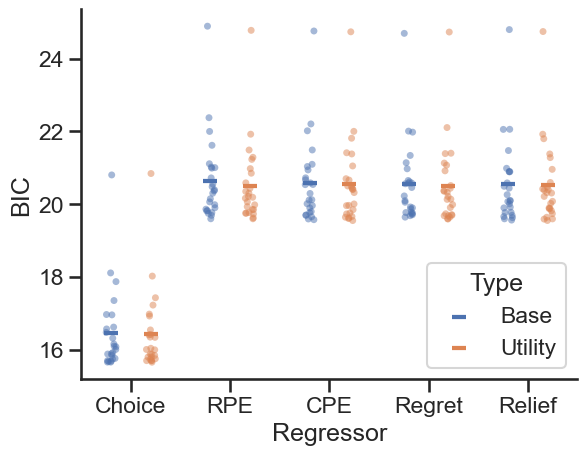

In [161]:
sns.stripplot(
    data=base_util_plot_data,  x="Regressor", y="BIC", hue='Type',
    dodge=True, alpha=.5, legend=False)
sns.pointplot(
    data=base_util_plot_data, x="Regressor", y="BIC", hue='Type',
    dodge=.4, linestyles='none',errorbar=None,
    markers="_")
sns.despine()

plt.savefig(f'{fig_dir}glm_bic_util_comp_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

In [162]:
base_util_plot_data

Model Regressor        BIC     Type
0           Base    Choice  16.152935     Base
0           Base    Choice  17.868648     Base
0           Base    Choice  16.313056     Base
0           Base    Choice  16.953757     Base
0           Base    Choice  16.004281     Base
..           ...       ...        ...      ...
0   dRelief_util    Relief  21.922507  Utility
0   dRelief_util    Relief  20.305022  Utility
0   dRelief_util    Relief  24.747239  Utility
0   dRelief_util    Relief  20.392761  Utility
0   dRelief_util    Relief  20.595686  Utility

[250 rows x 4 columns]

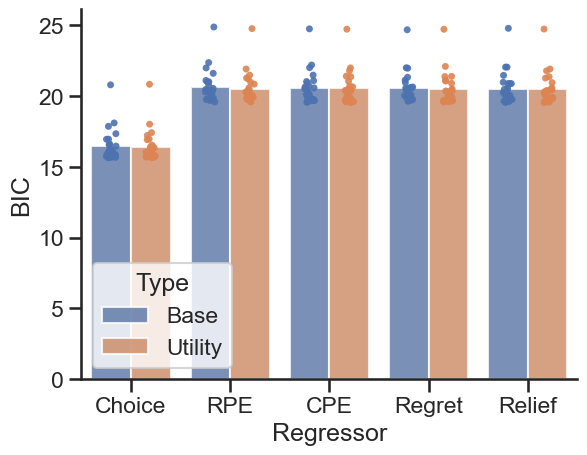

In [163]:
sns.stripplot(
    data=base_util_plot_data,  x="Regressor", y="BIC", hue='Type',
    dodge=True, alpha=0.9, legend=False)

sns.barplot(
    data=base_util_plot_data, x="Regressor", y="BIC", hue='Type',alpha=0.8,errorbar=None)#errwidth=0)

sns.despine() 

plt.savefig(f'{fig_dir}glm_bic_util_bars_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 


## Best 10 Model BIC Comparison Results
- Top 10 performing models with the lowest BICs selected


In [165]:
# top 10 model names for plotting

top10_models_list = ['Base_util',
                        'Base',
                        'dRegret_util',
                        'RPE_util',
                        'dRelief_util',
                        'pRPE',
                        'dRelief',
                        'dCPE_util',
                        'dRegret',
                        'dCPE']

In [166]:
# make base vs util bic comparison dfs
    # all subj BIC data for each model from all_results_dict
    # df with cols x = regressor name, y = BIC, color = util vs base 

# list of model names for comparison (selected from lowest BIC for each param) - grouped into tuples by regressor type

top10_plot_regressor_cats = ['Utility','EV','Regret Util','Relief Util','RPE Util','pRPE','Relief','Regret','CPE Util','CPE']


In [167]:
# iterate through plot models list - 

top10_plot_dict = {} # should contain reg cat, color cat, 
top10_plot_data = pd.DataFrame(columns=['Model','Regressor','BIC']) 
# base_util_plot_data = pd.DataFrame(columns=['Model','Regressor','Beta','Type']) 

for ix,name in enumerate(top10_models_list):
    #regressor name is same for model
    reg_name = top10_plot_regressor_cats[ix]
    #model var info - name, category for color
    # full_reg_name = models_dict[name][-1]
    # w_reg = all_results_dict[name][full_reg_name]
    # model_plot_dict = {'Regressor':[reg_name]*len(w_reg),'Type':[color]*len(w_reg),
    #                         'Model':[name]*len(w_reg),'Beta':w_reg}
    bic   = all_results_dict[name].bic
    top10_model_plot_dict = {'Regressor':[reg_name]*len(bic),
                                    'Model':[name]*len(bic),'BIC':bic}
    top10_plot_dict[name] = top10_model_plot_dict
    top10_plot_data = pd.concat([top10_plot_data,pd.DataFrame(top10_model_plot_dict)])

In [168]:
top10_plot_data

Model Regressor        BIC
0   Base_util   Utility  15.793381
0   Base_util   Utility  17.222597
0   Base_util   Utility  16.341879
0   Base_util   Utility  16.974752
0   Base_util   Utility  16.002323
..        ...       ...        ...
0        dCPE       CPE  22.016707
0        dCPE       CPE  20.540560
0        dCPE       CPE  24.762158
0        dCPE       CPE  20.940992
0        dCPE       CPE  21.034584

[250 rows x 3 columns]

In [169]:
top10_plot_data.groupby(['Regressor'])['BIC'].describe()

count       mean       std        min        25%        50%  \
Regressor                                                                  
CPE           25.0  20.590419  1.137105  19.572473  19.797057  20.293098   
CPE Util      25.0  20.547478  1.102983  19.642131  19.775804  20.225072   
EV            25.0  16.468595  1.135601  15.654698  15.756019  16.076889   
RPE Util      25.0  20.514144  1.107173  19.549407  19.873323  20.305022   
Regret        25.0  20.546060  1.122652  19.548009  19.757631  20.406445   
Regret Util   25.0  20.497616  1.110855  19.589815  19.711850  20.211231   
Relief        25.0  20.543384  1.142885  19.561264  19.773113  20.100384   
Relief Util   25.0  20.506167  1.092835  19.597327  19.850540  20.188176   
Utility       25.0  16.433937  1.112011  15.652107  15.790123  16.002323   
pRPE          25.0  20.533527  1.175503  19.600738  19.822971  20.055598   

                   75%        max  
Regressor                          
CPE          20.940992  24.762158  
CPE Util     20.650165  24.696882  
EV           16.617514  20.802516  
RPE Util     20.595686  24.747239  
Regret       20.698889  24.739458  
Regret Util  20.915667  24.733615  
Relief       20.889888  24.800658  
Relief Util  20.850152  24.780015  
Utility      16.539376  20.841751  
pRPE         20.725777  25.016240

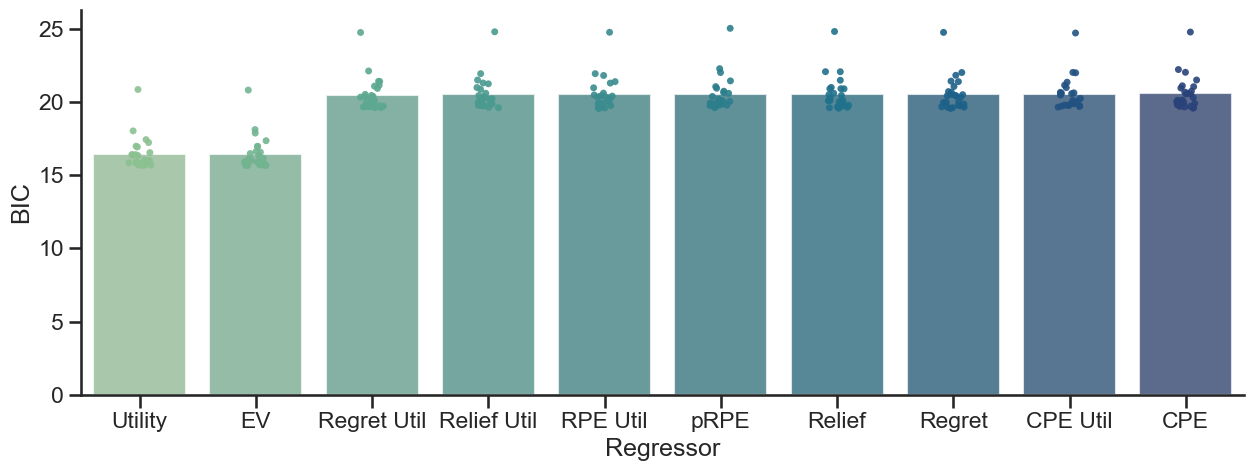

In [170]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.stripplot(ax=ax,
    data=top10_plot_data,  x="Regressor", y="BIC", palette='crest', #flare
    alpha=0.9, legend=False)

sns.barplot(ax=ax,
    data=top10_plot_data, x="Regressor", y="BIC",palette='crest',alpha=0.8,errorbar=None)#errwidth=0)

sns.despine() 

plt.savefig(f'{fig_dir}glm_bic_util_bars_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

## BDI Results

In [193]:
bdi_list = pd.read_excel(f'{base_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
bad_subj = ['DA026','MS028']
bad_subj_idx = [subj_ids.index(x) for x in subj_ids if x in bad_subj]
# bad_subj_idx = [subj_ids.index(x) for x in subj_ids if (x == bad_subj[0]) | (x==bad_subj[1])]
bdi_list = [bdi for ix, bdi in enumerate(bdi_list) if ix not in bad_subj_idx]


In [194]:
list(zip(good_subj_list,bdi_list))

[('DA8', 13),
 ('DA9', 32),
 ('DA10', 11),
 ('DA11', 41),
 ('DA023', 14),
 ('MS001', 24),
 ('MS002', 14),
 ('MS003', 8),
 ('MS004', 7),
 ('MS009', 16),
 ('MS011', 13),
 ('MS015', 26),
 ('MS016', 10),
 ('MS017', 26),
 ('MS019', 12),
 ('MS020', 6),
 ('MS022', 10),
 ('MS024', 16),
 ('MS025', 10),
 ('MS026', 9),
 ('MS027', 22),
 ('MS029', 32),
 ('MS030', 19),
 ('MS033', 39),
 ('MS035', 15)]

In [237]:
all_results_dict.keys()

dict_keys(['Base', 'RPE', 'nRPE', 'pRPE', 'nRPE_pRPE', 'tCPE', 'dCPE', 'RPE_tCPE', 'RPE_dCPE', 'tRegret', 'dRegret', 'tRelief', 'dRelief', 'nRPE_tReg', 'nRPE_dReg', 'pRPE_tRel', 'pRPE_dRel', 'nRPE_tReg_pRPE_tRel', 'nRPE_dReg_pRPE_dRel', 'Base_util', 'RPE_util', 'tCPE_util', 'dCPE_util', 'tCPE_RPE_util', 'dCPE_RPE_util', 'tRegret_util', 'dRegret_util', 'tRelief_util', 'dRelief_util', 'tReg_tRel_util', 'dReg_dRel_util', 'nRPE_tReg_util', 'nRPE_dReg_util', 'pRPE_tRel_util', 'pRPE_dRel_util', 'nRPE_tReg_pRPE_tRel_util', 'nRPE_dReg_pRPE_dRel_util', 'Base_util_RPE', 'Base_util_nRPE', 'Base_util_pRPE', 'Base_util_tCPE', 'Base_util_dCPE', 'Base_util_tRegret', 'Base_util_dRegret', 'Base_util_tRelief', 'Base_util_dRelief', 'Base_util_RPE_tCPE', 'Base_util_RPE_dCPE', 'Base_util_tRegret_tRelief', 'Base_util_dRegret_dRelief', 'Base_util_nRPE_tRegret_pRPE_tRelief', 'Base_util_nRPE_dRegret_pRPE_dRelief'])

In [238]:
# bdi_weights_plot_models_list = [('RPE_dCPE','dCPE_RPE_util'),
#                               ('nRPE_dReg_pRPE_dRel','nRPE_pRPE_dReg_dRel_util')]

bdi_weights_models_list = ['dRegret','dRegret_util','RPE_dCPE','dCPE_RPE_util',
                           'nRPE_dReg_pRPE_dRel','nRPE_dReg_pRPE_dRel_util']

bdi_weights_plot_nparams = [3,3,4,4,6,6]
bdi_weights_plot_regressor_cats = [['CR','EV','Regret'],['Util Safe','Util Gamble','Util Regret'],
                                   ['CR','EV','RPE','CPE'],['Util Safe','Util Gamble','Util RPE','Util CPE'],
                                   ['CR','EV','nRPE','Regret','pRPE','Relief'],
                                   ['Util Safe','Util Gamble','Util nRPE','Util Regret','Util pRPE','Util Relief']]

bdi_weights_plot_type_cats = ['Base','Utility','Base','Utility','Base','Utility']
# bdi_weights_plot_color_cats = ['High BDI','Low BDI']

subj_bdi_cat = np.array(bdi_list)
subj_bdi_cat[np.where(subj_bdi_cat<20)] = 0 # make sure this is first
subj_bdi_cat[np.where(subj_bdi_cat>=20)] = 1


bdi_weights_plot_dict = {} # should contain reg cat, color cat, 
bdi_weights_plot_data = pd.DataFrame(columns=['Model','Regressor','Var_ID','Type','Beta','BDI']) 

for ix,name in enumerate(bdi_weights_models_list):

    # model_name_list      = []
    # model_regressor_list = []
    # model_cols_list      = []
    # model_betas_list     = []
    # model_types_list     = []
    # model_bdis_list      = []

    fit_df = all_results_dict[name]
    col_names = fit_df.columns[-1*bdi_weights_plot_nparams[ix]:] #get column names from df
    weights = fit_df.loc[:,col_names]
    
    len_df = len(fit_df)*len(col_names)
    model_name_list      = [name]*len_df
    
    model_types_list = [bdi_weights_plot_type_cats[ix]]*len_df
    model_bdis_list = list(subj_bdi_cat)*len(col_names)
    

    model_betas_list = []
    model_regressor_list = []
    model_cols_list = []
    
    reg_names = bdi_weights_plot_regressor_cats[ix]
    # model_regressor_list = [reg_names[ir]]*len_df
    for ir,col in enumerate(col_names):
        
        model_betas_list     = model_betas_list +list(weights[col])
        reg_list             = [reg_names[ir]]*len(fit_df)
        model_regressor_list = model_regressor_list + reg_list
        cols_list            = [col]*len(fit_df)
        model_cols_list      = model_cols_list + cols_list


        
    model_bdi_dict = {'Model':model_name_list,'Regressor':model_regressor_list,'Var_ID':model_cols_list,
                                 'Type':model_types_list,'Beta':model_betas_list,'BDI':model_bdis_list}
    

    bdi_weights_plot_data = pd.concat([bdi_weights_plot_data,pd.DataFrame(model_bdi_dict)])
    bdi_weights_plot_dict[name] = model_bdi_dict
    # base_util_plot_data = pd.concat([base_util_plot_data,pd.DataFrame(model_plot_dict)])

In [239]:
bdi_weights_plot_data.groupby(['Regressor','BDI'])['Beta'].describe()

count      mean       std       min       25%       50%  \
Regressor   BDI                                                            
CPE         0     17.0  0.041707  0.247876 -0.437677 -0.089142  0.021932   
            1      8.0  0.220805  0.314099 -0.151229 -0.031375  0.205611   
CR          0     51.0  0.203255  1.223370 -5.290151 -0.072852  0.360712   
            1     24.0  0.002416  0.897184 -1.719009 -0.499723  0.039276   
EV          0     51.0  0.290292  0.400983 -0.505597  0.056292  0.272541   
            1     24.0  0.361571  0.454156 -0.888542  0.359661  0.513186   
RPE         0     17.0  0.508999  0.307449 -0.183632  0.353219  0.524031   
            1      8.0  0.168041  0.389012 -0.581655  0.053556  0.312821   
Regret      0     34.0  0.236030  0.472850 -1.170296 -0.014347  0.240858   
            1     16.0  0.493119  0.353098 -0.231874  0.333913  0.466090   
Relief      0     17.0  0.053605  0.367509 -0.444263 -0.158538 -0.058222   
            1      8.0 -0.034881  0.302223 -0.476198 -0.180523 -0.144489   
Util CPE    0     17.0  0.449775  1.108663 -0.317990  0.005894  0.142971   
            1      8.0  0.623356  0.615565 -0.413496  0.264443  0.625389   
Util Gamble 0     51.0 -0.090796  0.997491 -4.581935 -0.311809  0.054122   
            1     24.0  0.121536  0.621505 -1.493346 -0.245343  0.137542   
Util RPE    0     17.0  0.124135  0.947592 -3.203625 -0.110497  0.379617   
            1      8.0  0.114710  0.500622 -0.712643 -0.157657  0.132988   
Util Regret 0     34.0  0.660011  1.248606 -0.856615  0.010901  0.321195   
            1     16.0  0.341434  1.128149 -1.735320 -0.477246  0.592200   
Util Relief 0     17.0  0.369421  1.096390 -0.501424 -0.146909  0.039070   
            1      8.0  1.241609  1.761907 -0.193958  0.059540  0.561482   
Util Safe   0     51.0  0.706698  1.780741 -1.400923 -0.116771  0.322246   
            1     24.0  0.233103  1.066569 -2.069947 -0.527742  0.180865   
Util nRPE   0     17.0  0.212666  1.095659 -3.632622  0.184925  0.433538   
            1      8.0  0.048481  0.583029 -0.827655 -0.333148  0.116966   
Util pRPE   0     17.0  1.315943  2.843016 -0.527832  0.119532  0.471061   
            1      8.0 -0.193469  3.435807 -8.050149  0.058818  0.581248   
nRPE        0     17.0  0.664122  0.713669 -0.358863  0.259662  0.516909   
            1      8.0  0.136899  0.450670 -0.724310 -0.037801  0.155189   
pRPE        0     17.0  0.342429  0.441962 -0.471544  0.115237  0.439294   
            1      8.0  0.329878  0.445910 -0.438982  0.213319  0.441416   

                      75%        max  
Regressor   BDI                       
CPE         0    0.090434   0.800183  
            1    0.360481   0.761324  
CR          0    0.842191   1.533285  
            1    0.792319   1.119747  
EV          0    0.595430   1.369214  
            1    0.609396   0.804354  
RPE         0    0.737005   0.982842  
            1    0.383658   0.535300  
Regret      0    0.389423   1.243073  
            1    0.661469   1.273928  
Relief      0    0.118701   1.180685  
            1    0.172885   0.472063  
Util CPE    0    0.280379   4.432919  
            1    0.985923   1.610684  
Util Gamble 0    0.383745   0.943997  
            1    0.583314   1.239549  
Util RPE    0    0.504951   0.919441  
            1    0.302069   0.993543  
Util Regret 0    0.968919   5.848751  
            1    1.361541   1.928874  
Util Relief 0    0.242412   3.823557  
            1    1.783114   4.970730  
Util Safe   0    0.636858   8.555862  
            1    0.884914   2.839278  
Util nRPE   0    0.838259   1.060021  
            1    0.513643   0.734659  
Util pRPE   0    0.814509  10.000000  
            1    0.926614   3.715573  
nRPE        0    0.952553   2.322135  
            1    0.334378   0.748218  
pRPE        0    0.589637   1.219688  
            1    0.585803   0.847415

In [240]:
bdi_weights_plot_data

Model    Regressor              Var_ID     Type  \
0                     dRegret           CR                  CR     Base   
1                     dRegret           CR                  CR     Base   
2                     dRegret           CR                  CR     Base   
3                     dRegret           CR                  CR     Base   
4                     dRegret           CR                  CR     Base   
..                        ...          ...                 ...      ...   
145  nRPE_dReg_pRPE_dRel_util  Util Relief  util_dRelief_emmap  Utility   
146  nRPE_dReg_pRPE_dRel_util  Util Relief  util_dRelief_emmap  Utility   
147  nRPE_dReg_pRPE_dRel_util  Util Relief  util_dRelief_emmap  Utility   
148  nRPE_dReg_pRPE_dRel_util  Util Relief  util_dRelief_emmap  Utility   
149  nRPE_dReg_pRPE_dRel_util  Util Relief  util_dRelief_emmap  Utility   

         Beta BDI  
0   -0.784748   0  
1   -0.455107   1  
2    1.311617   0  
3    0.733607   1  
4    0.380023   0  
..        ...  ..  
145 -0.110620   1  
146 -0.193958   1  
147 -0.146909   0  
148  0.311484   1  
149  2.189073   0  

[650 rows x 6 columns]

In [241]:
np.unique(bdi_weights_plot_data.Model)

array(['RPE_dCPE', 'dCPE_RPE_util', 'dRegret', 'dRegret_util',
       'nRPE_dReg_pRPE_dRel', 'nRPE_dReg_pRPE_dRel_util'], dtype=object)

### BDI x Regret/Regret Util

In [242]:
bdi_reg_base_data = bdi_weights_plot_data[bdi_weights_plot_data.Model=='dRegret']
bdi_reg_base_data.BDI[bdi_reg_base_data.BDI==1] = 'High'
bdi_reg_base_data.BDI[bdi_reg_base_data.BDI==0] = 'Low'
bdi_reg_util_data = bdi_weights_plot_data[bdi_weights_plot_data.Model=='dRegret_util']
bdi_reg_util_data.BDI[bdi_reg_util_data.BDI==1] = 'High'
bdi_reg_util_data.BDI[bdi_reg_util_data.BDI==0] = 'Low'

/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_21237/1289346234.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdi_reg_base_data.BDI[bdi_reg_base_data.BDI==1] = 'High'
/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_21237/1289346234.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdi_reg_base_data.BDI[bdi_reg_base_data.BDI==1] = 'High'
/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_21237/1289346234.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [243]:
bdi_reg_base_data.groupby(['Regressor','BDI'])['Beta'].describe()

count      mean       std       min       25%       50%  \
Regressor BDI                                                             
CR        High    8.0  0.029851  0.853811 -1.624087 -0.311027  0.071285   
          Low    17.0  0.138853  1.447732 -4.995903  0.069454  0.282382   
EV        High    8.0  0.373453  0.387203 -0.497432  0.359661  0.411914   
          Low    17.0  0.208118  0.477583 -0.505597 -0.090142  0.151149   
Regret    High    8.0  0.572263  0.392090  0.108051  0.309106  0.537106   
          Low    17.0  0.435392  0.458868 -0.424768  0.156877  0.393312   

                     75%       max  
Regressor BDI                       
CR        High  0.755162  0.885000  
          Low   0.913628  1.345011  
EV        High  0.576582  0.739749  
          Low   0.529637  1.369214  
Regret    High  0.712497  1.273928  
          Low   0.767069  1.243073

In [244]:
bdi_reg_util_data.groupby(['Regressor','BDI'])['Beta'].describe()

count      mean       std       min       25%       50%  \
Regressor   BDI                                                             
Util Gamble High    8.0  0.342124  0.398999 -0.340727  0.138721  0.280747   
            Low    17.0  0.040020  0.446672 -0.730756 -0.322987  0.054122   
Util Regret High    8.0  0.627020  0.964502 -0.843992  0.005156  0.660106   
            Low    17.0  0.710870  1.000863 -0.478742  0.059251  0.410305   
Util Safe   High    8.0 -0.037160  1.009331 -2.069947 -0.248527  0.082457   
            Low    17.0  0.525073  1.282770 -1.400923 -0.009556  0.344347   

                       75%       max  
Regressor   BDI                       
Util Gamble High  0.659946  0.872436  
            Low   0.409815  0.943997  
Util Regret High  1.400855  1.928874  
            Low   1.200883  3.199439  
Util Safe   High  0.398431  1.247695  
            Low   0.625371  4.812066

In [245]:
# Quick Stats - 
params_to_test = ['CR', 'choiceEV', 'decisionRegret']

bdi_reg_base_stats = {}
for param in params_to_test:
    dep = bdi_reg_base_data.loc[(bdi_reg_base_data.Var_ID == param)&(bdi_reg_base_data.BDI == "High"), "Beta"].values
    ndep = bdi_reg_base_data.loc[(bdi_reg_base_data.Var_ID == param)&(bdi_reg_base_data.BDI == "Low"), "Beta"].values
    _,p = mannwhitneyu(dep, ndep, alternative="two-sided")
    bdi_reg_base_stats[param] = p

bdi_reg_base_stats

{'CR': 0.43979566835402073,
 'choiceEV': 0.1943184707486767,
 'decisionRegret': 0.34399833576034944}

In [248]:
bdi_reg_util_data[bdi_reg_util_data.Var_ID == 'util_dRegret_emmap']

Model    Regressor              Var_ID     Type      Beta   BDI
50  dRegret_util  Util Regret  util_dRegret_emmap  Utility  0.068010   Low
51  dRegret_util  Util Regret  util_dRegret_emmap  Utility  1.381281  High
52  dRegret_util  Util Regret  util_dRegret_emmap  Utility  1.518492   Low
53  dRegret_util  Util Regret  util_dRegret_emmap  Utility  1.459577  High
54  dRegret_util  Util Regret  util_dRegret_emmap  Utility  0.538095   Low
55  dRegret_util  Util Regret  util_dRegret_emmap  Utility  0.125206  High
56  dRegret_util  Util Regret  util_dRegret_emmap  Utility -0.451249   Low
57  dRegret_util  Util Regret  util_dRegret_emmap  Utility -0.180322   Low
58  dRegret_util  Util Regret  util_dRegret_emmap  Utility  0.515666   Low
59  dRegret_util  Util Regret  util_dRegret_emmap  Utility  0.410305   Low
60  dRegret_util  Util Regret  util_dRegret_emmap  Utility  1.050842   Low
61  dRegret_util  Util Regret  util_dRegret_emmap  Utility -0.354997  High
62  dRegret_util  Util Regret  util_dRegret_emmap  Utility  0.302882   Low
63  dRegret_util  Util Regret  util_dRegret_emmap  Utility  1.928874  High
64  dRegret_util  Util Regret  util_dRegret_emmap  Utility  1.200883   Low
65  dRegret_util  Util Regret  util_dRegret_emmap  Utility  0.059251   Low
66  dRegret_util  Util Regret  util_dRegret_emmap  Utility  3.199439   Low
67  dRegret_util  Util Regret  util_dRegret_emmap  Utility  1.736142   Low
68  dRegret_util  Util Regret  util_dRegret_emmap  Utility  0.339508   Low
69  dRegret_util  Util Regret  util_dRegret_emmap  Utility -0.478742   Low
70  dRegret_util  Util Regret  util_dRegret_emmap  Utility -0.843992  High
71  dRegret_util  Util Regret  util_dRegret_emmap  Utility  0.366229  High
72  dRegret_util  Util Regret  util_dRegret_emmap  Utility -0.005216   Low
73  dRegret_util  Util Regret  util_dRegret_emmap  Utility  0.953983  High
74  dRegret_util  Util Regret  util_dRegret_emmap  Utility  2.260797   Low

In [246]:
# Quick Stats - 
params_to_test = ['util_safe_emmap','util_gamble_emmap','util_dRegret_emmap']


bdi_reg_util_stats = {}
for param in params_to_test:
    dep = bdi_reg_util_data.loc[(bdi_reg_util_data.Var_ID == param)&(bdi_reg_util_data.BDI == "High"), "Beta"].values
    ndep = bdi_reg_util_data.loc[(bdi_reg_util_data.Var_ID == param)&(bdi_reg_util_data.BDI == "Low"), "Beta"].values
    _,p = mannwhitneyu(dep, ndep, alternative="two-sided")
    bdi_reg_util_stats[param] = p

bdi_reg_util_stats

{'util_safe_emmap': 0.34399833576034944,
 'util_gamble_emmap': 0.15657906294061902,
 'util_dRegret_emmap': 1.0}

### BDI x Regret/Relief & nRPE/pRPE

In [199]:
bdi_full_base_data = bdi_weights_plot_data[bdi_weights_plot_data.Model=='nRPE_dReg_pRPE_dRel']
bdi_full_base_data.BDI[bdi_full_base_data.BDI==1] = 'High'
bdi_full_base_data.BDI[bdi_full_base_data.BDI==0] = 'Low'
bdi_full_util_data = bdi_weights_plot_data[bdi_weights_plot_data.Model=='nRPE_dReg_pRPE_dRel_util']
bdi_full_util_data.BDI[bdi_full_util_data.BDI==1] = 'High'
bdi_full_util_data.BDI[bdi_full_util_data.BDI==0] = 'Low'

/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_21237/226023734.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdi_full_base_data.BDI[bdi_full_base_data.BDI==1] = 'High'
/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_21237/226023734.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdi_full_base_data.BDI[bdi_full_base_data.BDI==1] = 'High'
/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_21237/226023734.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

In [200]:
bdi_full_base_data

Model Regressor          Var_ID  Type      Beta   BDI
0    nRPE_dReg_pRPE_dRel        CR              CR  Base -0.546326   Low
1    nRPE_dReg_pRPE_dRel        CR              CR  Base -0.744024  High
2    nRPE_dReg_pRPE_dRel        CR              CR  Base  1.039892   Low
3    nRPE_dReg_pRPE_dRel        CR              CR  Base  0.744592  High
4    nRPE_dReg_pRPE_dRel        CR              CR  Base  0.113917   Low
..                   ...       ...             ...   ...       ...   ...
145  nRPE_dReg_pRPE_dRel    Relief  decisionRelief  Base -0.476198  High
146  nRPE_dReg_pRPE_dRel    Relief  decisionRelief  Base  0.248847  High
147  nRPE_dReg_pRPE_dRel    Relief  decisionRelief  Base  0.059593   Low
148  nRPE_dReg_pRPE_dRel    Relief  decisionRelief  Base -0.139795  High
149  nRPE_dReg_pRPE_dRel    Relief  decisionRelief  Base  1.180685   Low

[150 rows x 6 columns]

In [201]:
bdi_full_base_data.groupby(['Regressor','BDI'])['Beta'].describe()

count      mean       std       min       25%       50%  \
Regressor BDI                                                             
CR        High    8.0 -0.040830  1.011197 -1.719009 -0.759419  0.051174   
          Low    17.0  0.438865  0.544778 -0.546326 -0.067651  0.406697   
EV        High    8.0  0.387283  0.449203 -0.669605  0.408054  0.559891   
          Low    17.0  0.333313  0.379798 -0.404929  0.077639  0.282530   
Regret    High    8.0  0.413976  0.314827 -0.231874  0.333913  0.383052   
          Low    17.0  0.036668  0.407590 -1.170296 -0.050388  0.177496   
Relief    High    8.0 -0.034881  0.302223 -0.476198 -0.180523 -0.144489   
          Low    17.0  0.053605  0.367509 -0.444263 -0.158538 -0.058222   
nRPE      High    8.0  0.136899  0.450670 -0.724310 -0.037801  0.155189   
          Low    17.0  0.664122  0.713669 -0.358863  0.259662  0.516909   
pRPE      High    8.0  0.329878  0.445910 -0.438982  0.213319  0.441416   
          Low    17.0  0.342429  0.441962 -0.471544  0.115237  0.439294   

                     75%       max  
Regressor BDI                       
CR        High  0.802271  1.119747  
          Low   0.713774  1.533285  
EV        High  0.608814  0.682425  
          Low   0.606505  1.004416  
Regret    High  0.661469  0.757919  
          Low   0.293699  0.377757  
Relief    High  0.172885  0.472063  
          Low   0.118701  1.180685  
nRPE      High  0.334378  0.748218  
          Low   0.952553  2.322135  
pRPE      High  0.585803  0.847415  
          Low   0.589637  1.219688

In [202]:
np.unique(bdi_full_base_data.Var_ID)

array(['CR', 'choiceEV', 'decisionRegret', 'decisionRelief', 'nRPE',
       'pRPE'], dtype=object)

In [205]:
# Quick Stats - 
params_to_test = ['CR', 'choiceEV', 'decisionRegret', 'decisionRelief', 'nRPE', 'pRPE']

bdi_full_base_stats = {}
for param in params_to_test:
    dep = bdi_full_base_data.loc[(bdi_full_base_data.Var_ID == param)&(bdi_full_base_data.BDI == "High"), "Beta"].values
    ndep = bdi_full_base_data.loc[(bdi_full_base_data.Var_ID == param)&(bdi_full_base_data.BDI == "Low"), "Beta"].values
    _,p = mannwhitneyu(dep, ndep, alternative="two-sided")
    bdi_full_base_stats[param] = p

bdi_full_base_stats


{'CR': 0.3744169382613318,
 'choiceEV': 0.47467813142870346,
 'decisionRegret': 0.009005385664424567,
 'decisionRelief': 0.6275644315003582,
 'nRPE': 0.07522548135820448,
 'pRPE': 0.9318909923028919}

### Plot bdi_full_base_data

In [206]:
bdi_full_base_stats.keys()

dict_keys(['CR', 'choiceEV', 'decisionRegret', 'decisionRelief', 'nRPE', 'pRPE'])

In [208]:
bdi_full_base_data

Model Regressor          Var_ID  Type      Beta   BDI
0    nRPE_dReg_pRPE_dRel        CR              CR  Base -0.546326   Low
1    nRPE_dReg_pRPE_dRel        CR              CR  Base -0.744024  High
2    nRPE_dReg_pRPE_dRel        CR              CR  Base  1.039892   Low
3    nRPE_dReg_pRPE_dRel        CR              CR  Base  0.744592  High
4    nRPE_dReg_pRPE_dRel        CR              CR  Base  0.113917   Low
..                   ...       ...             ...   ...       ...   ...
145  nRPE_dReg_pRPE_dRel    Relief  decisionRelief  Base -0.476198  High
146  nRPE_dReg_pRPE_dRel    Relief  decisionRelief  Base  0.248847  High
147  nRPE_dReg_pRPE_dRel    Relief  decisionRelief  Base  0.059593   Low
148  nRPE_dReg_pRPE_dRel    Relief  decisionRelief  Base -0.139795  High
149  nRPE_dReg_pRPE_dRel    Relief  decisionRelief  Base  1.180685   Low

[150 rows x 6 columns]

In [209]:
model_id = bdi_full_base_data.Model[0]
model_id

'nRPE_dReg_pRPE_dRel'

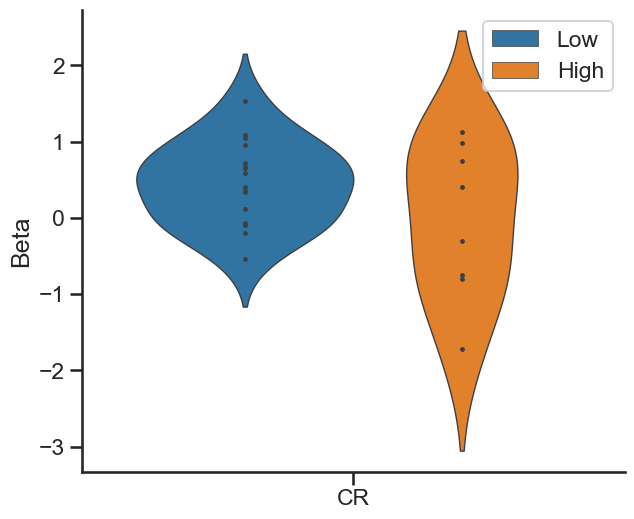

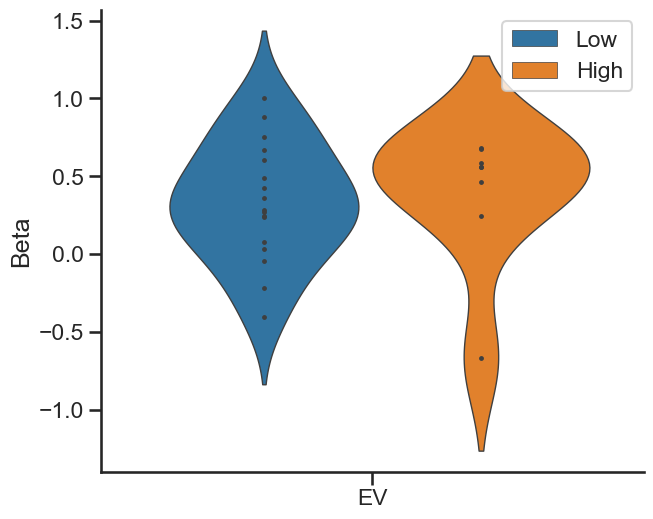

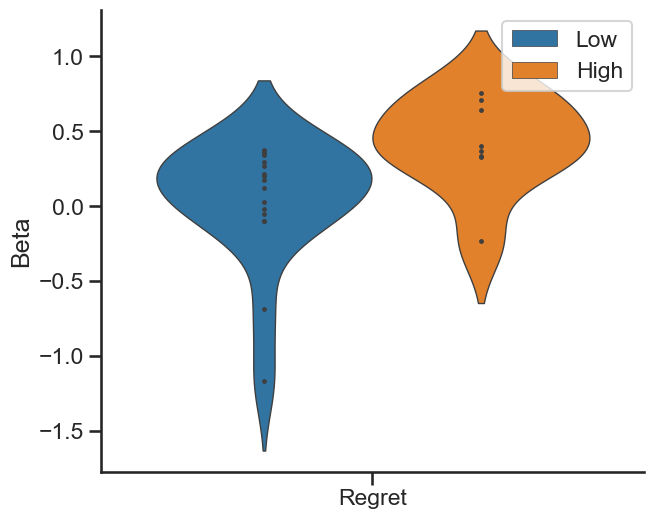

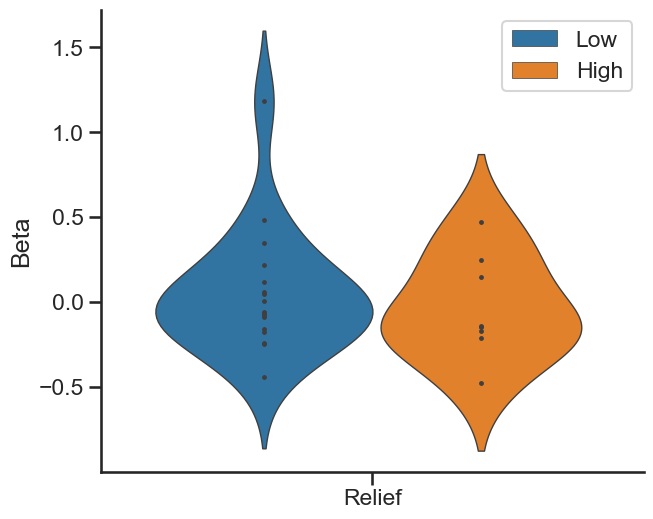

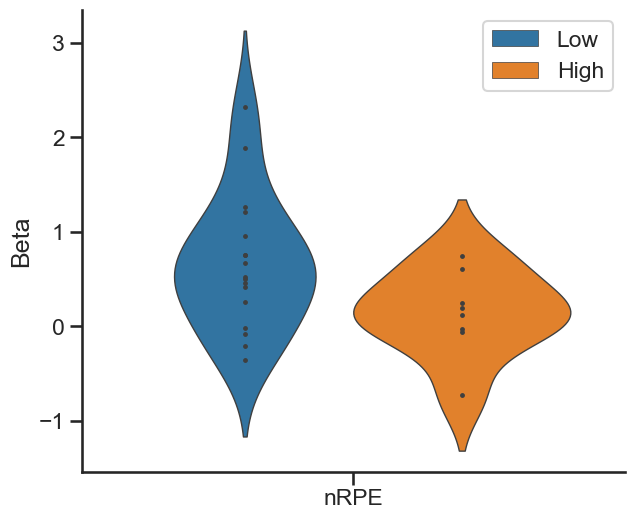

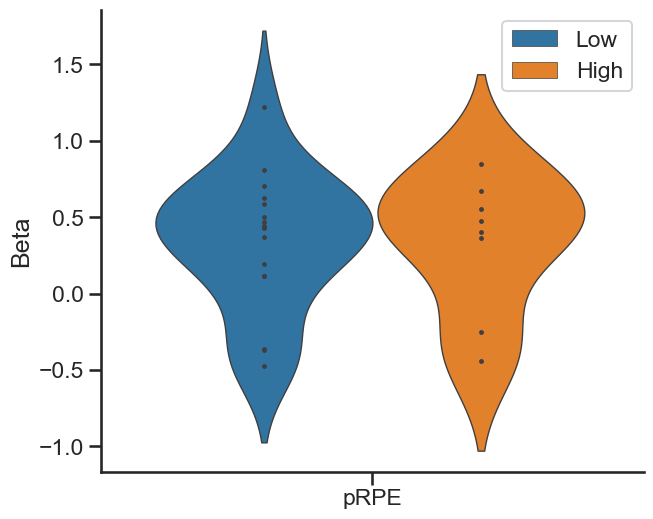

In [210]:
plot_vars = ['CR', 'choiceEV', 'decisionRegret', 'decisionRelief', 'nRPE', 'pRPE']

for var in plot_vars:

    model_id = model_id = bdi_full_base_data.Model[0]
    plot_data = bdi_full_base_data[(bdi_full_base_data.Var_ID == var)]

    fig, ax = plt.subplots(figsize=(7, 6))

    sns.violinplot(ax=ax,
        data=plot_data, x='Regressor', y="Beta", hue='BDI',palette='tab10',
        scale='area',split=False,linewidth=1,legend=False,inner='point')#errwidth=0)
    ax.legend()
    ax.set(xlabel=None)

    
    sns.despine() 


    plt.savefig(f'{fig_dir}{model_id}_{var}_bdi_betas_{date}.pdf', dpi=500, format='pdf', metadata=None,
    bbox_inches='tight', pad_inches=0.2,
    facecolor='auto', edgecolor='auto',
    backend=None) 

In [211]:
bdi_full_util_data

Model    Regressor              Var_ID     Type  \
0    nRPE_dReg_pRPE_dRel_util    Util Safe     util_safe_emmap  Utility   
1    nRPE_dReg_pRPE_dRel_util    Util Safe     util_safe_emmap  Utility   
2    nRPE_dReg_pRPE_dRel_util    Util Safe     util_safe_emmap  Utility   
3    nRPE_dReg_pRPE_dRel_util    Util Safe     util_safe_emmap  Utility   
4    nRPE_dReg_pRPE_dRel_util    Util Safe     util_safe_emmap  Utility   
..                        ...          ...                 ...      ...   
145  nRPE_dReg_pRPE_dRel_util  Util Relief  util_dRelief_emmap  Utility   
146  nRPE_dReg_pRPE_dRel_util  Util Relief  util_dRelief_emmap  Utility   
147  nRPE_dReg_pRPE_dRel_util  Util Relief  util_dRelief_emmap  Utility   
148  nRPE_dReg_pRPE_dRel_util  Util Relief  util_dRelief_emmap  Utility   
149  nRPE_dReg_pRPE_dRel_util  Util Relief  util_dRelief_emmap  Utility   

         Beta   BDI  
0   -0.344621   Low  
1   -1.429131  High  
2    0.222204   Low  
3    0.060590  High  
4    0.037081   Low  
..        ...   ...  
145 -0.110620  High  
146 -0.193958  High  
147 -0.146909   Low  
148  0.311484  High  
149  2.189073   Low  

[150 rows x 6 columns]

In [212]:
bdi_full_util_data.groupby(['Var_ID','BDI'])['Beta'].describe()

count      mean       std       min       25%  \
Var_ID             BDI                                                   
util_dRegret_emmap High    8.0  0.055848  1.269082 -1.735320 -1.125360   
                   Low    17.0  0.609152  1.486018 -0.856615 -0.058946   
util_dRelief_emmap High    8.0  1.241609  1.761907 -0.193958  0.059540   
                   Low    17.0  0.369421  1.096390 -0.501424 -0.146909   
util_gamble_emmap  High    8.0 -0.125673  0.884979 -1.493346 -0.470329   
                   Low    17.0 -0.220074  1.184544 -4.530013 -0.383547   
util_nRPE_emmap    High    8.0  0.048481  0.583029 -0.827655 -0.333148   
                   Low    17.0  0.212666  1.095659 -3.632622  0.184925   
util_pRPE_emmap    High    8.0 -0.193469  3.435807 -8.050149  0.058818   
                   Low    17.0  1.315943  2.843016 -0.527832  0.119532   
util_safe_emmap    High    8.0  0.408222  1.341867 -1.429131 -0.224211   
                   Low    17.0  0.878760  2.071748 -0.344621 -0.119390   

                              50%       75%        max  
Var_ID             BDI                                  
util_dRegret_emmap High  0.382093  0.978356   1.531893  
                   Low   0.216576  0.578548   5.848751  
util_dRelief_emmap High  0.561482  1.783114   4.970730  
                   Low   0.039070  0.242412   3.823557  
util_gamble_emmap  High -0.182177  0.259193   1.239549  
                   Low  -0.019754  0.348995   0.752342  
util_nRPE_emmap    High  0.116966  0.513643   0.734659  
                   Low   0.433538  0.838259   1.060021  
util_pRPE_emmap    High  0.581248  0.926614   3.715573  
                   Low   0.471061  0.814509  10.000000  
util_safe_emmap    High  0.418171  0.954424   2.839278  
                   Low   0.567774  0.657269   8.555862

In [213]:
# Quick Stats - 
params_to_test = ['util_safe_emmap','util_gamble_emmap','util_nRPE_emmap','util_dRegret_emmap','util_pRPE_emmap','util_dRelief_emmap']

bdi_full_util_stats = {}
for param in params_to_test:
    dep = bdi_full_util_data.loc[(bdi_full_util_data.Var_ID == param)&(bdi_full_util_data.BDI == "High"), "Beta"].values
    ndep = bdi_full_util_data.loc[(bdi_full_util_data.Var_ID == param)&(bdi_full_util_data.BDI == "Low"), "Beta"].values
    _,p = mannwhitneyu(dep, ndep, alternative="two-sided")
    bdi_full_util_stats[param] = p

bdi_full_util_stats

{'util_safe_emmap': 0.9772637126412872,
 'util_gamble_emmap': 0.8867013383260525,
 'util_nRPE_emmap': 0.23800291241938837,
 'util_dRegret_emmap': 0.7975332270069113,
 'util_pRPE_emmap': 1.0,
 'util_dRelief_emmap': 0.13984605783232787}

In [214]:
bdi_full_util_data

Model    Regressor              Var_ID     Type  \
0    nRPE_dReg_pRPE_dRel_util    Util Safe     util_safe_emmap  Utility   
1    nRPE_dReg_pRPE_dRel_util    Util Safe     util_safe_emmap  Utility   
2    nRPE_dReg_pRPE_dRel_util    Util Safe     util_safe_emmap  Utility   
3    nRPE_dReg_pRPE_dRel_util    Util Safe     util_safe_emmap  Utility   
4    nRPE_dReg_pRPE_dRel_util    Util Safe     util_safe_emmap  Utility   
..                        ...          ...                 ...      ...   
145  nRPE_dReg_pRPE_dRel_util  Util Relief  util_dRelief_emmap  Utility   
146  nRPE_dReg_pRPE_dRel_util  Util Relief  util_dRelief_emmap  Utility   
147  nRPE_dReg_pRPE_dRel_util  Util Relief  util_dRelief_emmap  Utility   
148  nRPE_dReg_pRPE_dRel_util  Util Relief  util_dRelief_emmap  Utility   
149  nRPE_dReg_pRPE_dRel_util  Util Relief  util_dRelief_emmap  Utility   

         Beta   BDI  
0   -0.344621   Low  
1   -1.429131  High  
2    0.222204   Low  
3    0.060590  High  
4    0.037081   Low  
..        ...   ...  
145 -0.110620  High  
146 -0.193958  High  
147 -0.146909   Low  
148  0.311484  High  
149  2.189073   Low  

[150 rows x 6 columns]

In [215]:
np.unique(bdi_full_util_data.Var_ID)

array(['util_dRegret_emmap', 'util_dRelief_emmap', 'util_gamble_emmap',
       'util_nRPE_emmap', 'util_pRPE_emmap', 'util_safe_emmap'],
      dtype=object)

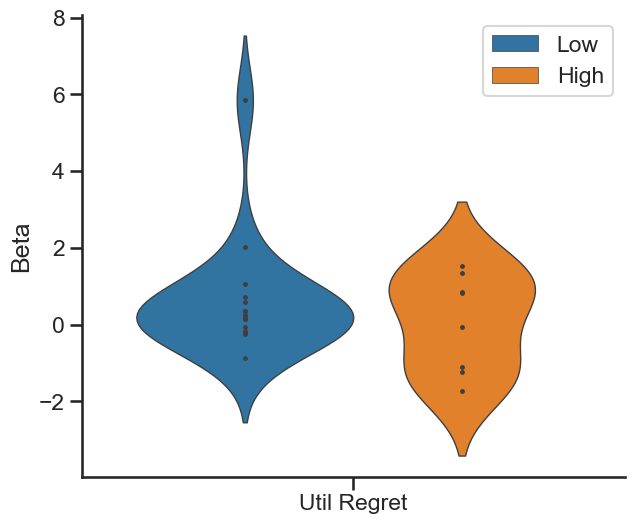

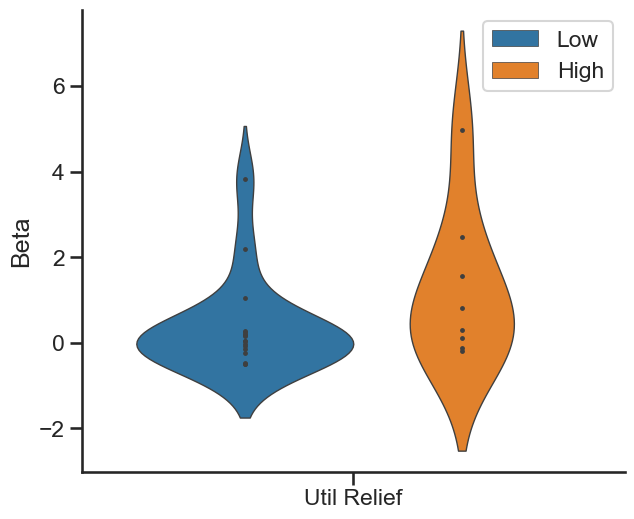

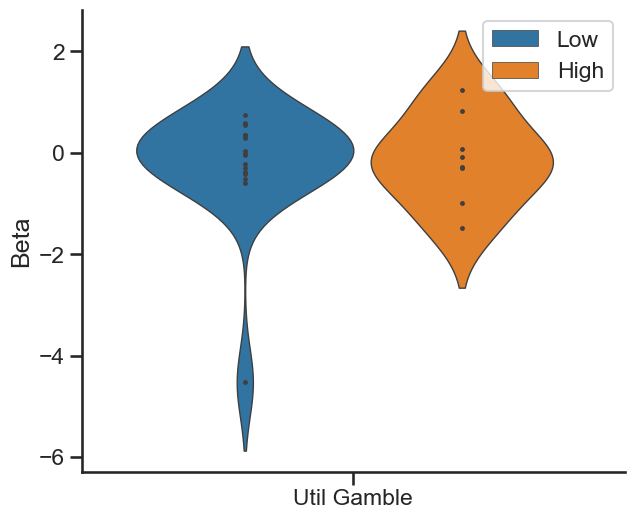

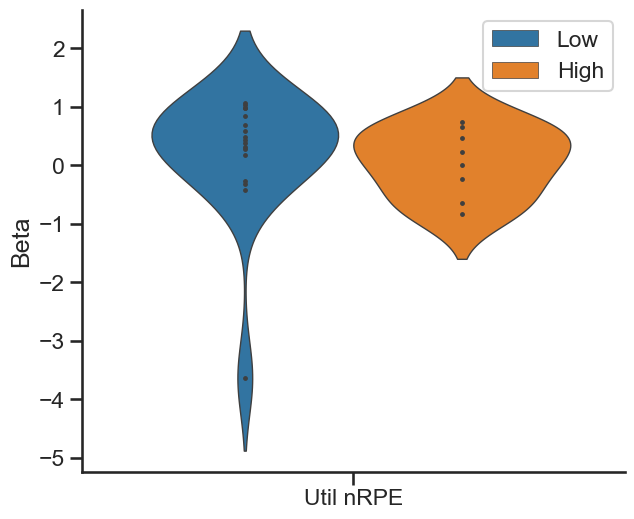

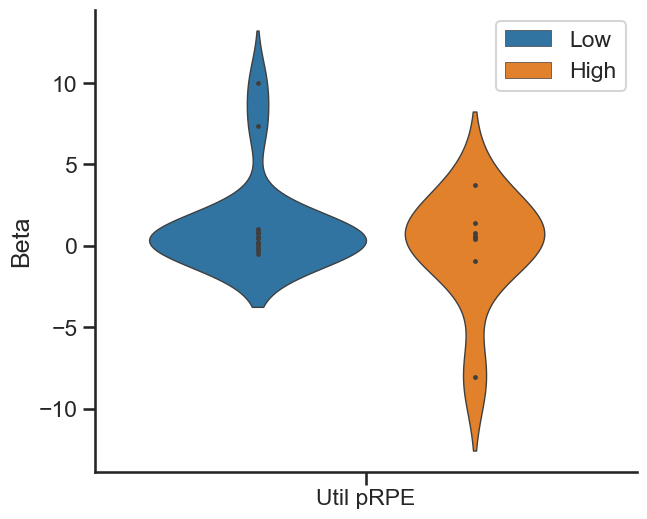

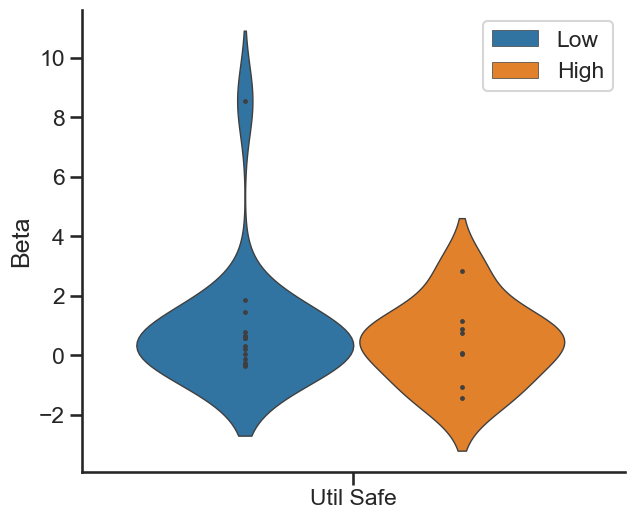

In [216]:
plot_vars = ['util_dRegret_emmap', 'util_dRelief_emmap', 'util_gamble_emmap',
       'util_nRPE_emmap', 'util_pRPE_emmap', 'util_safe_emmap']

for var in plot_vars:

    model_id = model_id = bdi_full_util_data.Model[0]
    plot_data = bdi_full_util_data[(bdi_full_util_data.Var_ID == var)]

    fig, ax = plt.subplots(figsize=(7, 6))

    sns.violinplot(ax=ax,
        data=plot_data, x='Regressor', y="Beta", hue='BDI',palette='tab10',
        scale='area',split=False,linewidth=1,legend=False,inner='point')#errwidth=0)
    ax.legend()
    ax.set(xlabel=None)

    
    sns.despine() 


    plt.savefig(f'{fig_dir}{model_id}_{var}_bdi_betas_{date}.pdf', dpi=500, format='pdf', metadata=None,
    bbox_inches='tight', pad_inches=0.2,
    facecolor='auto', edgecolor='auto',
    backend=None) 

In [ ]:
# from scipy.stats import mannwhitneyu, normaltest
# dep = cpe_vars.loc[(cpe_vars.BDI == "High"), "Beta"].values
# ndep = cpe_vars.loc[(cpe_vars.BDI == "Low"), "Beta"].values

# mannwhitneyu(dep, ndep, alternative="two-sided")
# stat_results = [
#   mannwhitneyu(robots, flight, alternative="two-sided"),
#   mannwhitneyu(flight, sound, alternative="two-sided"),
#   mannwhitneyu(robots, sound, alternative="two-sided")
# ]

# pvalues = [result.pvalue for result in stat_results]

# print("Robots vs Flight: \n", stat_results[0], "\n")
# print("Flight vs Sound: \n", stat_results[1], "\n")
# print("robots vs Sound: \n", stat_results[2], "\n")

## BDI x CPE & RPE

In [217]:
bdi_cpe_rpe_base_data = bdi_weights_plot_data[bdi_weights_plot_data.Model=='RPE_dCPE']
bdi_cpe_rpe_base_data.BDI[bdi_cpe_rpe_base_data.BDI==1] = 'High'
bdi_cpe_rpe_base_data.BDI[bdi_cpe_rpe_base_data.BDI==0] = 'Low'
bdi_cpe_rpe_util_data = bdi_weights_plot_data[bdi_weights_plot_data.Model=='dCPE_RPE_util']
bdi_cpe_rpe_util_data.BDI[bdi_cpe_rpe_util_data.BDI==1] = 'High'
bdi_cpe_rpe_util_data.BDI[bdi_cpe_rpe_util_data.BDI==0] = 'Low'

/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_21237/536908058.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdi_cpe_rpe_base_data.BDI[bdi_cpe_rpe_base_data.BDI==1] = 'High'
/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_21237/536908058.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdi_cpe_rpe_base_data.BDI[bdi_cpe_rpe_base_data.BDI==1] = 'High'
/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_21237/536908058.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

In [218]:
bdi_cpe_rpe_base_data

Model Regressor       Var_ID  Type      Beta   BDI
0   RPE_dCPE        CR           CR  Base -0.625048   Low
1   RPE_dCPE        CR           CR  Base -0.463470  High
2   RPE_dCPE        CR           CR  Base  1.065759   Low
3   RPE_dCPE        CR           CR  Base  0.783150  High
4   RPE_dCPE        CR           CR  Base  0.430743   Low
..       ...       ...          ...   ...       ...   ...
95  RPE_dCPE       CPE  decisionCPE  Base -0.151229  High
96  RPE_dCPE       CPE  decisionCPE  Base  0.299072  High
97  RPE_dCPE       CPE  decisionCPE  Base  0.027894   Low
98  RPE_dCPE       CPE  decisionCPE  Base -0.013420  High
99  RPE_dCPE       CPE  decisionCPE  Base  0.800183   Low

[100 rows x 6 columns]

In [219]:
bdi_cpe_rpe_base_data.groupby(['Regressor','BDI'])['Beta'].describe()

count      mean       std       min       25%       50%  \
Regressor BDI                                                             
CPE       High    8.0  0.220805  0.314099 -0.151229 -0.031375  0.205611   
          Low    17.0  0.041707  0.247876 -0.437677 -0.089142  0.021932   
CR        High    8.0  0.018227  0.943399 -1.672010 -0.499723  0.034828   
          Low    17.0  0.032046  1.479775 -5.290151 -0.100806  0.409512   
EV        High    8.0  0.323978  0.568736 -0.888542  0.297003  0.530840   
          Low    17.0  0.329447  0.345484 -0.495690  0.170477  0.279934   
RPE       High    8.0  0.168041  0.389012 -0.581655  0.053556  0.312821   
          Low    17.0  0.508999  0.307449 -0.183632  0.353219  0.524031   

                     75%       max  
Regressor BDI                       
CPE       High  0.360481  0.761324  
          Low   0.090434  0.800183  
CR        High  0.834399  1.048830  
          Low   0.786249  1.299887  
EV        High  0.623793  0.804354  
          Low   0.591828  0.897358  
RPE       High  0.383658  0.535300  
          Low   0.737005  0.982842

In [220]:
np.unique(bdi_cpe_rpe_base_data.Var_ID)

array(['CR', 'RPE', 'choiceEV', 'decisionCPE'], dtype=object)

In [221]:
# Quick Stats - 
params_to_test = ['CR', 'RPE', 'choiceEV', 'decisionCPE']

bdi_cpe_rpe_base_stats = {}
for param in params_to_test:
    dep = bdi_cpe_rpe_base_data.loc[(bdi_cpe_rpe_base_data.Var_ID == param)&(bdi_cpe_rpe_base_data.BDI == "High"), "Beta"].values
    ndep = bdi_cpe_rpe_base_data.loc[(bdi_cpe_rpe_base_data.Var_ID == param)&(bdi_cpe_rpe_base_data.BDI == "Low"), "Beta"].values
    _,p = mannwhitneyu(dep, ndep, alternative="two-sided")
    bdi_cpe_rpe_base_stats[param] = p

bdi_cpe_rpe_base_stats

{'CR': 0.5875117305780921,
 'RPE': 0.026603795390980744,
 'choiceEV': 0.6275644315003582,
 'decisionCPE': 0.21540993458613594}

In [222]:
np.unique(bdi_cpe_rpe_base_data.Var_ID)

array(['CR', 'RPE', 'choiceEV', 'decisionCPE'], dtype=object)

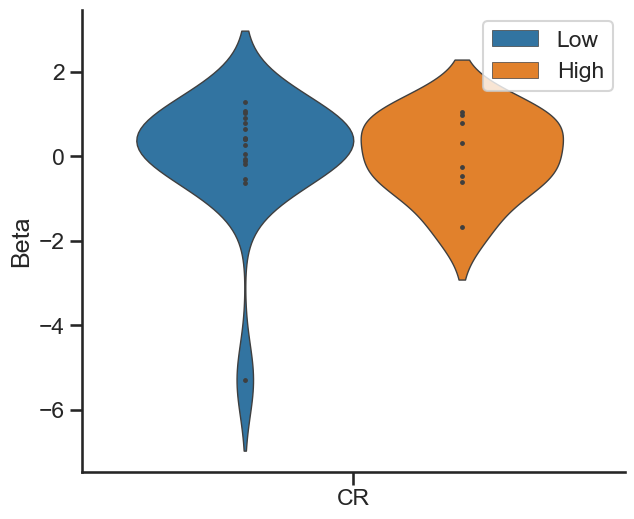

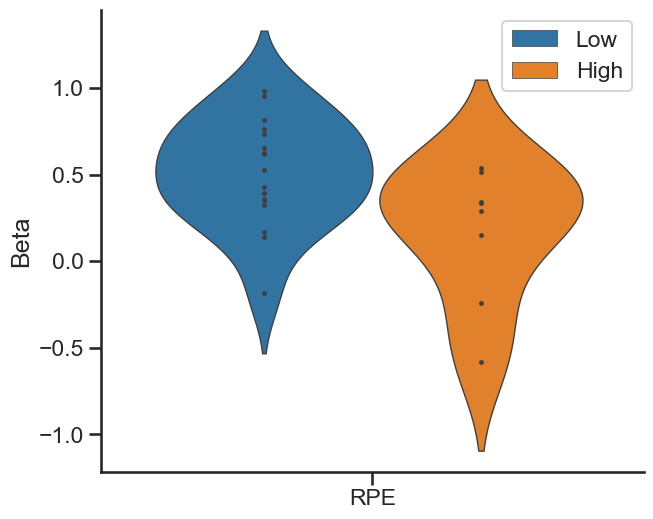

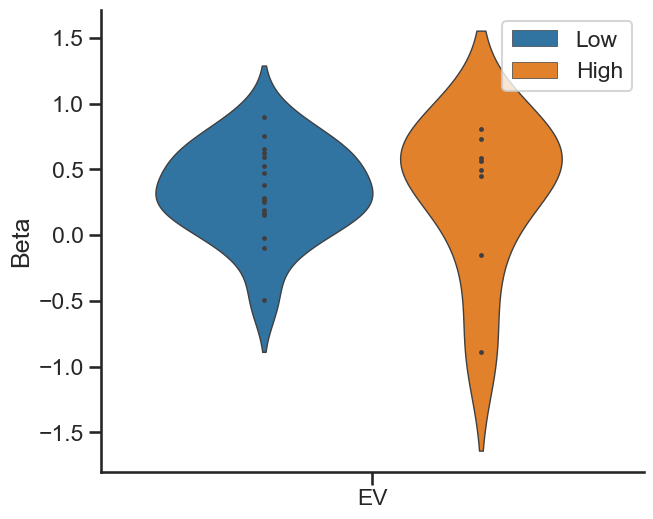

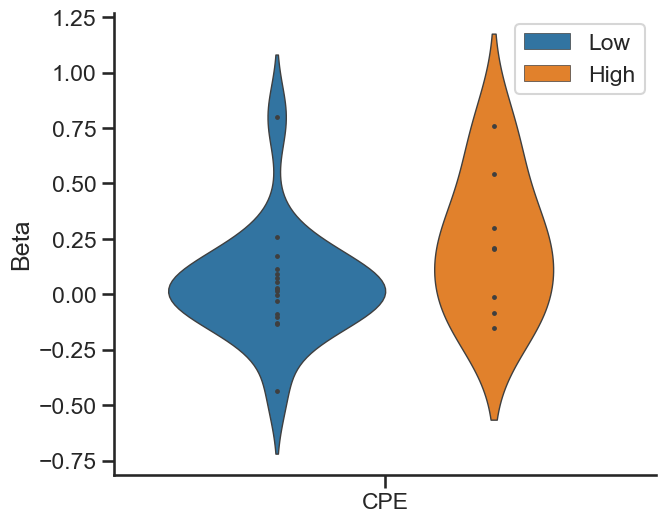

In [223]:
np.unique(bdi_cpe_rpe_base_data.Var_ID)
plot_vars = ['CR', 'RPE', 'choiceEV', 'decisionCPE']

for var in plot_vars:

    model_id = model_id = bdi_cpe_rpe_base_data.Model[0]
    plot_data = bdi_cpe_rpe_base_data[(bdi_cpe_rpe_base_data.Var_ID == var)]

    fig, ax = plt.subplots(figsize=(7, 6))

    sns.violinplot(ax=ax,
        data=plot_data, x='Regressor', y="Beta", hue='BDI',palette='tab10',
        scale='area',split=False,linewidth=1,legend=False,inner='point')#errwidth=0)
    ax.legend()
    ax.set(xlabel=None)

    
    sns.despine() 


    plt.savefig(f'{fig_dir}{model_id}_{var}_bdi_betas_{date}.pdf', dpi=500, format='pdf', metadata=None,
    bbox_inches='tight', pad_inches=0.2,
    facecolor='auto', edgecolor='auto',
    backend=None) 

In [224]:
bdi_cpe_rpe_util_data

Model  Regressor           Var_ID     Type      Beta   BDI
0   dCPE_RPE_util  Util Safe  util_safe_emmap  Utility -0.322896   Low
1   dCPE_RPE_util  Util Safe  util_safe_emmap  Utility -0.738072  High
2   dCPE_RPE_util  Util Safe  util_safe_emmap  Utility  0.071888   Low
3   dCPE_RPE_util  Util Safe  util_safe_emmap  Utility  0.169227  High
4   dCPE_RPE_util  Util Safe  util_safe_emmap  Utility -0.114152   Low
..            ...        ...              ...      ...       ...   ...
95  dCPE_RPE_util   Util CPE  util_dCPE_emmap  Utility -0.413496  High
96  dCPE_RPE_util   Util CPE  util_dCPE_emmap  Utility  0.274210  High
97  dCPE_RPE_util   Util CPE  util_dCPE_emmap  Utility  0.062443   Low
98  dCPE_RPE_util   Util CPE  util_dCPE_emmap  Utility  0.533505  High
99  dCPE_RPE_util   Util CPE  util_dCPE_emmap  Utility  1.606657   Low

[100 rows x 6 columns]

In [225]:
bdi_cpe_rpe_util_data.groupby(['Regressor','BDI'])['Beta'].describe()

count      mean       std       min       25%       50%  \
Regressor   BDI                                                             
Util CPE    High    8.0  0.623356  0.615565 -0.413496  0.264443  0.625389   
            Low    17.0  0.449775  1.108663 -0.317990  0.005894  0.142971   
Util Gamble High    8.0  0.148159  0.447789 -0.504590 -0.130481  0.076555   
            Low    17.0 -0.092335  1.212740 -4.581935 -0.222660  0.198260   
Util RPE    High    8.0  0.114710  0.500622 -0.712643 -0.157657  0.132988   
            Low    17.0  0.124135  0.947592 -3.203625 -0.110497  0.379617   
Util Safe   High    8.0  0.328247  0.888538 -0.738072 -0.527742  0.407047   
            Low    17.0  0.716262  1.976170 -0.623989 -0.133809  0.098333   

                       75%       max  
Regressor   BDI                       
Util CPE    High  0.985923  1.610684  
            Low   0.280379  4.432919  
Util Gamble High  0.537806  0.771986  
            Low   0.466534  0.780225  
Util RPE    High  0.302069  0.993543  
            Low   0.504951  0.919441  
Util Safe   High  0.926289  1.530555  
            Low   0.567859  7.963103

In [226]:
np.unique(bdi_cpe_rpe_util_data.Var_ID)

array(['util_RPE_emmap', 'util_dCPE_emmap', 'util_gamble_emmap',
       'util_safe_emmap'], dtype=object)

In [227]:
# Quick Stats - 
params_to_test = ['util_RPE_emmap', 'util_dCPE_emmap', 'util_gamble_emmap',
       'util_safe_emmap']

bdi_cpe_rpe_util_stats = {}
for param in params_to_test:
    dep = bdi_cpe_rpe_util_data.loc[(bdi_cpe_rpe_util_data.Var_ID == param)&(bdi_cpe_rpe_util_data.BDI == "High"), "Beta"].values
    ndep = bdi_cpe_rpe_util_data.loc[(bdi_cpe_rpe_util_data.Var_ID == param)&(bdi_cpe_rpe_util_data.BDI == "Low"), "Beta"].values
    _,p = mannwhitneyu(dep, ndep, alternative="two-sided")
    bdi_cpe_rpe_util_stats[param] = p

bdi_cpe_rpe_util_stats

{'util_RPE_emmap': 0.4063444513787763,
 'util_dCPE_emmap': 0.09749115872685668,
 'util_gamble_emmap': 0.8418889120033286,
 'util_safe_emmap': 0.9772637126412872}

In [228]:
np.unique(bdi_cpe_rpe_util_data.Var_ID)

array(['util_RPE_emmap', 'util_dCPE_emmap', 'util_gamble_emmap',
       'util_safe_emmap'], dtype=object)

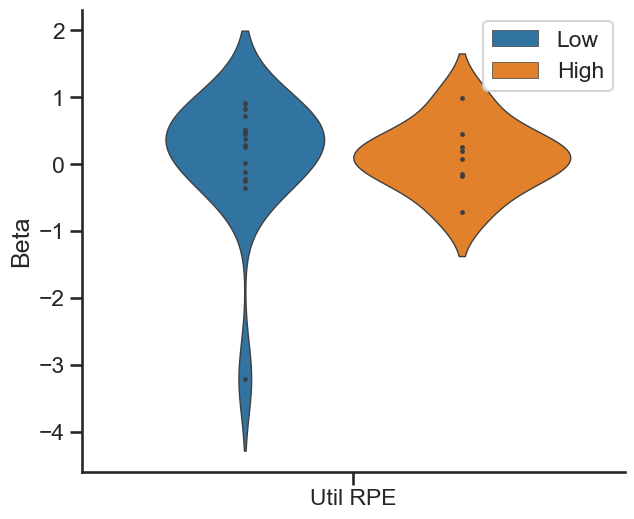

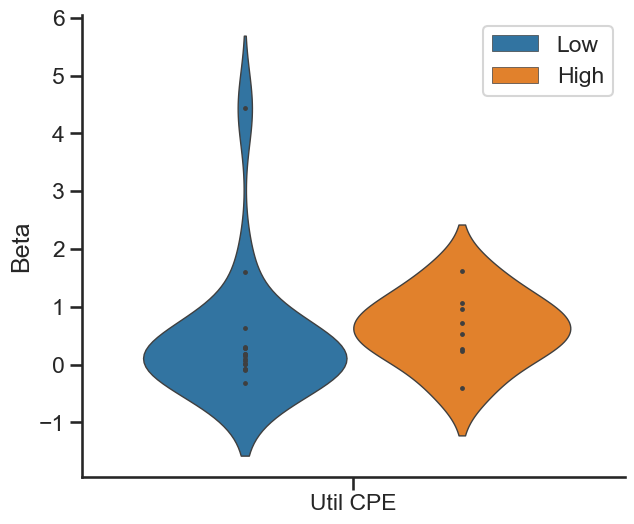

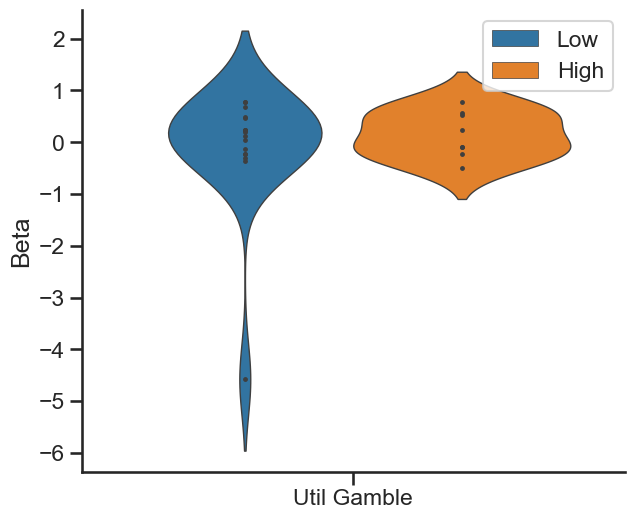

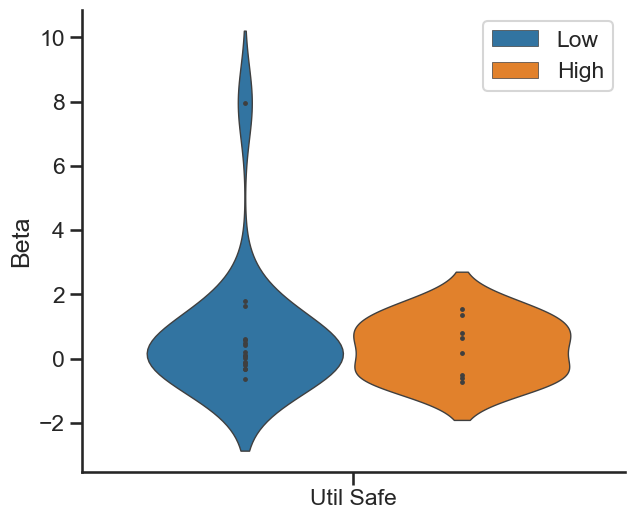

In [229]:
np.unique(bdi_cpe_rpe_util_data.Var_ID)
plot_vars = ['util_RPE_emmap', 'util_dCPE_emmap', 'util_gamble_emmap',
       'util_safe_emmap']

for var in plot_vars:

    model_id = model_id = bdi_cpe_rpe_util_data.Model[0]
    plot_data = bdi_cpe_rpe_util_data[(bdi_cpe_rpe_util_data.Var_ID == var)]

    fig, ax = plt.subplots(figsize=(7, 6))

    sns.violinplot(ax=ax,
        data=plot_data, x='Regressor', y="Beta", hue='BDI',palette='tab10',
        scale='area',split=False,linewidth=1,legend=False,inner='point')#errwidth=0)
    ax.legend()
    ax.set(xlabel=None)

    
    sns.despine() 


    plt.savefig(f'{fig_dir}{model_id}_{var}_bdi_betas_{date}.pdf', dpi=500, format='pdf', metadata=None,
    bbox_inches='tight', pad_inches=0.2,
    facecolor='auto', edgecolor='auto',
    backend=None) 

In [ ]:
#### stats for future - 
# from scipy.stats import mannwhitneyu, normaltest
# dep = cpe_vars.loc[(cpe_vars.BDI == "High"), "Beta"].values
# ndep = cpe_vars.loc[(cpe_vars.BDI == "Low"), "Beta"].values

# mannwhitneyu(dep, ndep, alternative="two-sided")
# stat_results = [
#   mannwhitneyu(robots, flight, alternative="two-sided"),
#   mannwhitneyu(flight, sound, alternative="two-sided"),
#   mannwhitneyu(robots, sound, alternative="two-sided")
# ]

# pvalues = [result.pvalue for result in stat_results]

# print("Robots vs Flight: \n", stat_results[0], "\n")
# print("Flight vs Sound: \n", stat_results[1], "\n")
# print("robots vs Sound: \n", stat_results[2], "\n")

# pvalues = [
#     sci_stats.mannwhitneyu(robots, flight, alternative="two-sided").pvalue,
#     sci_stats.mannwhitneyu(flight, sound, alternative="two-sided").pvalue,
#     sci_stats.mannwhitneyu(robots, sound, alternative="two-sided").pvalue
# ]
# # Transform each p-value to "p=" in scientific notation
# formatted_pvalues = [f'p={pvalue:.2e}' for pvalue in pvalues]
# annotator.set_custom_annotations(formatted_pvalues) 

# # Putting the parameters in a dictionary avoids code duplication
# # since we use the same for `sns.boxplot` and `Annotator` calls
# plotting_parameters = {
#     'data':    rfs,
#     'x':       'Subcategory',
#     'y':       'Goal',
#     'palette': subcat_palette[1:]
# }

# pairs = [('Robots', 'Flight'),
#          ('Flight', 'Sound'),
#          ('Robots', 'Sound')]

# with sns.plotting_context('notebook', font_scale = 1.4):
#     # Create new plot
#     ax = get_log_ax()

#     # Plot with seaborn
#     sns.boxplot(**plotting_parameters)

#     # Add annotations
#     annotator = Annotator(ax, pairs, **plotting_parameters)
#     annotator.set_custom_annotations(formatted_pvalues)
#     annotator.annotate()

#     # Label and show
#     label_plot_for_subcats(ax)
#     plt.show()
# #https://levelup.gitconnected.com/statistics-on-seaborn-plots-with-statannotations-2bfce0394c00


<Axes: xlabel='Regressor', ylabel='Beta'>

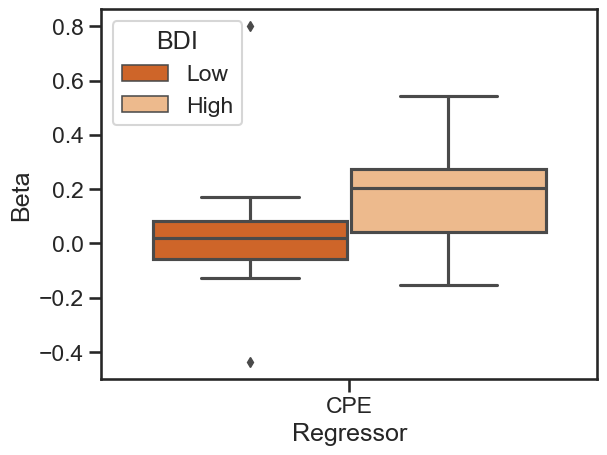

In [48]:
# sns.boxplot(data=cpe_vars, x='Regressor',y='Beta', hue='BDI',palette='Oranges_r')
# 

In [651]:
# sns.displot(data=bdi_cpe_rpe_base_data, x="Beta", hue="Regressor", kind="kde")

/Users/alexandrafink/opt/anaconda3/envs/swb_behav_models/lib/python3.11/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.2980392156862745, 0.4470588235294118, 0.6901960784313725)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/alexandrafink/opt/anaconda3/envs/swb_behav_models/lib/python3.11/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.8666666666666667, 0.5176470588235295, 0.3215686274509804)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,


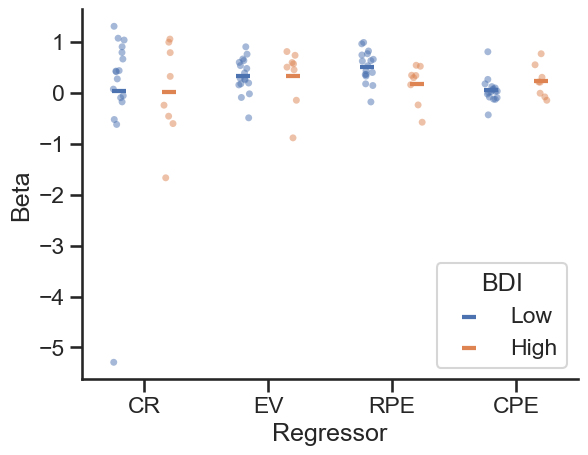

In [230]:
sns.stripplot(
    data=bdi_cpe_rpe_base_data,  x="Regressor", y="Beta", hue='BDI',
    dodge=True, alpha=.5, legend=False,native_scale=False)
sns.pointplot(
    data=bdi_cpe_rpe_base_data, x="Regressor", y="Beta", hue='BDI',
    dodge=.4, linestyles='none',errorbar=None,
    markers="_")
sns.despine()

# plt.savefig(f'{fig_dir}glm_bic_util_comp_{date}.pdf', dpi=500, format='pdf', metadata=None,
# bbox_inches='tight', pad_inches=0.2,
# facecolor='auto', edgecolor='auto',
# backend=None) 

<Axes: xlabel='Regressor', ylabel='Beta'>

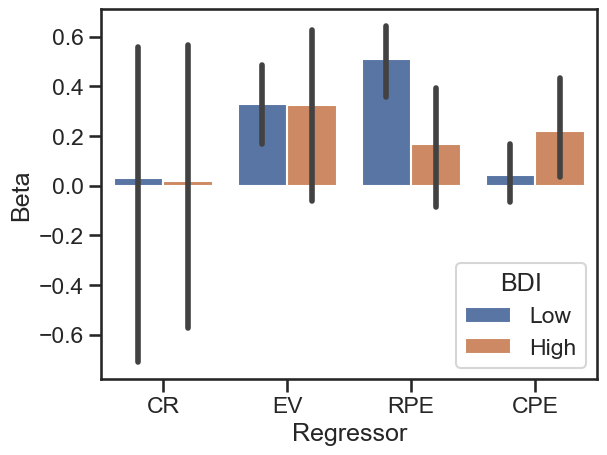

In [231]:
sns.barplot(
    data=bdi_cpe_rpe_base_data, x="Regressor", y="Beta", hue='BDI')#errwidth=0)

In [232]:
cpe_vars = bdi_cpe_rpe_base_data[bdi_cpe_rpe_base_data.Regressor=='CPE']

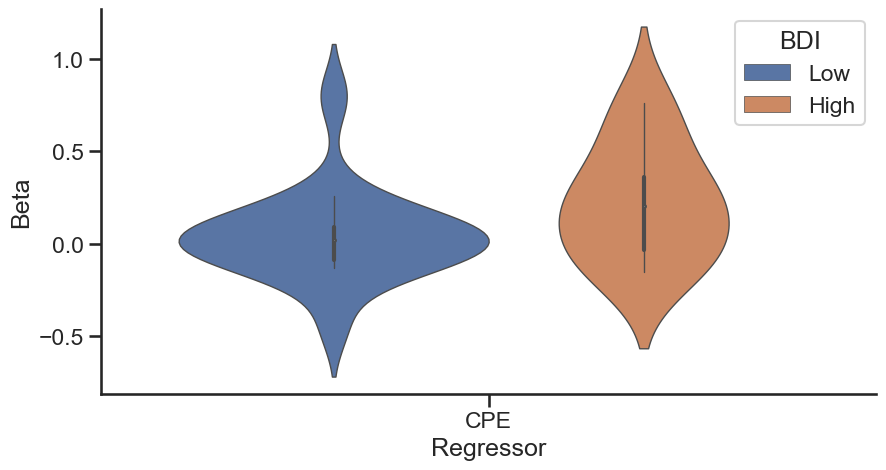

In [233]:
fig, ax = plt.subplots(figsize=(10, 5))


sns.violinplot(ax=ax,
    data=cpe_vars, x="Regressor", y="Beta", hue='BDI',native_scale=False,
    density_norm='width',split=False,linewidth=1)#errwidth=0)


sns.despine() 



# plt.savefig(f'{fig_dir}glm_bic_util_bars_{date}.pdf', dpi=500, format='pdf', metadata=None,
# bbox_inches='tight', pad_inches=0.2,
# facecolor='auto', edgecolor='auto',
# backend=None) 

<Axes: xlabel='Regressor', ylabel='Beta'>

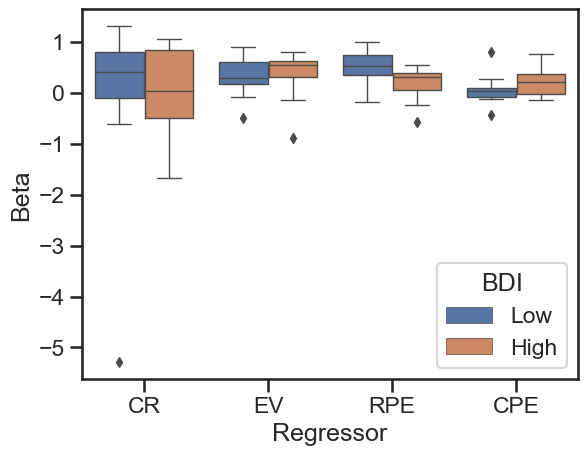

In [234]:
sns.boxplot(
    data=bdi_cpe_rpe_base_data,  x="Regressor", y="Beta", hue='BDI',
    dodge=True,linewidth=1)
    # dodge=True, alpha=0.9, legend=False)

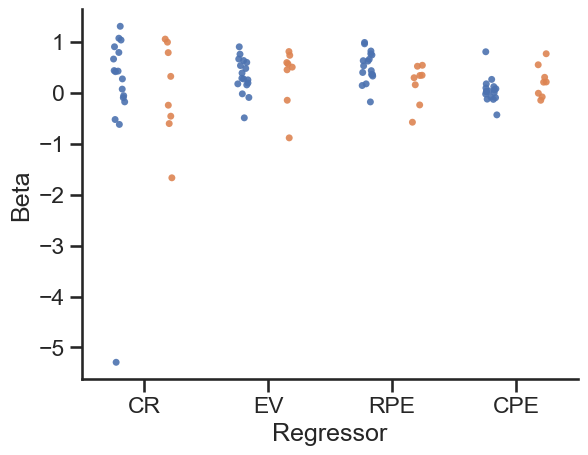

In [235]:
sns.stripplot(
    data=bdi_cpe_rpe_base_data,  x="Regressor", y="Beta", hue='BDI',
    dodge=True, alpha=0.9, legend=False)

# sns.boxplot(
#     data=bdi_cpe_rpe_base_data, x="Regressor", y="Beta", hue='BDI')#errwidth=0)

sns.despine() 

# plt.savefig(f'{fig_dir}glm_bic_util_bars_{date}.pdf', dpi=500, format='pdf', metadata=None,
# bbox_inches='tight', pad_inches=0.2,
# facecolor='auto', edgecolor='auto',
# backend=None) 


In [ ]:
# # make base vs util bic comparison dfs
#     # all subj BIC data for each model from all_results_dict
#     # df with cols x = regressor name, y = BIC, color = util vs base 

# # list of model names for comparison (selected from lowest BIC for each param) - grouped into tuples by regressor type

# bdi_plot_models_list = [('Base','Base_util'),
#                               ('RPE','RPE_util'),
#                               ('dCPE','dCPE_util'),
#                               ('dRegret','dRegret_util'),
#                               ('dRelief','dRelief_util'),
#                               ('RPE_dCPE','dCPE_RPE_util')
#                               ('nRPE_dReg_pRPE_dRel','nRPE_pRPE_dReg_dRel_util')]

# bdi_plot_regressor_cats = ['Choice','RPE','CPE','Regret','Relief','RPE_CPE','Full']
# bdi_plot_color_cats = ['Base','Utility']


In [ ]:
# # iterate through plot models list - 

# base_util_plot_dict = {} # should contain reg cat, color cat, 
# base_util_plot_data = pd.DataFrame(columns=['Model','Regressor','BIC','Type']) 

# for ix,model_names in enumerate(base_util_plot_models_list):
#     #regressor name is same for both models
#     reg_name = base_util_plot_regressor_cats[ix]
#     #model var info - name, category for color
#     for x in range(len(model_names)):
#         name  = model_names[x] #first item in tuple will be base model name 
#         color = base_util_plot_color_cats[x]# hard coded since there are so few options
#         bic   = all_results_dict[name].bic
#         model_plot_dict = {'Regressor':[reg_name]*len(bic),'Type':[color]*len(bic),
#                                      'Model':[name]*len(bic),'BIC':bic}
#         base_util_plot_dict[name] = model_plot_dict
#         base_util_plot_data = pd.concat([base_util_plot_data,pd.DataFrame(model_plot_dict)])

References:
- https://shawnrhoads.github.io/gu-psyc-347/module-02-01_Nonlinear-Modeling.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html
- https://hernandis.me/2020/04/05/three-examples-of-nonlinear-least-squares-fitting-in-python-with-scipy.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html#scipy.optimize.OptimizeResult
- https://www.nedcharles.com/regression/Nonlinear_Least_Squares_Regression_For_Python.html
